# Universidad Nacional de Colombia - Sede Bogotá

# Minería de Datos

# Avance del Proyecto #1

## __Presentado por:__ 
* Sebastián Alvarez Montoya - sfalvarezm@unal.edu.co
* Oscar Alberto Bustos B. - oabustosb@unal.edu.co

## Carga de Datos

In [ ]:
!pip install prince

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.mixture import GaussianMixture as gmm
import prince
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
!gdown --id 1BD8FkdVE8taqLjVelt-t5GirN_YUzZCK -O carsdata.csv

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BD8FkdVE8taqLjVelt-t5GirN_YUzZCK
To: /content/carsdata.csv
100% 2.70M/2.70M [00:00<00:00, 143MB/s]


In [ ]:
rawdata = pd.read_csv("carsdata.csv")
rawdata.head(3)

Year    Make         Model Used/New    Price  ConsumerRating  \
0  2019  Toyota     Sienna SE     Used  $39,998             4.6   
1  2018    Ford  F-150 Lariat     Used  $49,985             4.8   
2  2017     RAM  1500 Laramie     Used  $41,860             4.7   

   ConsumerReviews SellerType  \
0               45     Dealer   
1              817     Dealer   
2              495     Dealer   

                                          SellerName  SellerRating  ...  \
0  CarMax Murrieta - Now offering Curbside Pickup...           3.3  ...   
1                                    Giant Chevrolet           4.8  ...   
2                             Gill Auto Group Madera           4.6  ...   

   InteriorColor         Drivetrain MinMPG MaxMPG  FuelType  \
0          Black  Front-wheel Drive     19     27  Gasoline   
1          Black   Four-wheel Drive     19     24  Gasoline   
2          Black   Four-wheel Drive     15     21  Gasoline   

         Transmission                           Engine                VIN  \
0   8-Speed Automatic             3.5L V6 24V PDI DOHC  5TDXZ3DC2KS015402   
1  10-Speed Automatic  3.5L V6 24V PDI DOHC Twin Turbo  1FTEW1EG2JFD44217   
2   8-Speed Automatic             5.7L V8 16V MPFI OHV  1C6RR7VT5HS842283   

      Stock#  Mileage  
0   22998646    29403  
1     22418A    32929  
2  NG277871G    23173  

[3 rows x 32 columns]

## Limpieza de Datos (cleansing)

### Datos Perdidos

Se debe hacer cambios o transformaciones a los datos. El primero es para la variable 'Used/New', ya que aconsejan cambiar todos los tipos de valores cerfitified por la especifica empresa a solo certified.

In [ ]:
#revisar valores de Used/New, deben cambiarse los diferentes certified a solo la variable Certified. Lo aconseja Kaggle
rawdata['Used/New'].unique()

array(['Used', 'Dodge Certified', 'Acura Certified', 'Honda Certified',
       'Mercedes-Benz Certified', 'Ford Certified', 'Toyota Certified',
       'BMW Certified', 'Porsche Certified', 'Cadillac Certified',
       'Volvo Certified', 'Nissan Certified', 'Subaru Certified',
       'Volkswagen Certified', 'INFINITI Certified',
       'Chevrolet Certified', 'Kia Certified', 'RAM Certified',
       'Jeep Certified', 'GMC Certified', 'Buick Certified',
       'Alfa Romeo Certified', 'Bentley Certified', 'MINI Certified',
       'Ferrari Certified', 'Maserati Certified'], dtype=object)

Lo otro es colocar valores a los faltantes en la variable 'Price'. Para esto, se revisa los vehiculos que no cuentan con precio.

In [ ]:
print('La cantidad de vehiculos sin precio es {}.'.format(len(rawdata[rawdata['Price'] == 'Not Priced'])))
idx_price = rawdata[rawdata['Price'] == 'Not Priced'][['Make', 'Model']].index.tolist()
rawdata[rawdata['Price'] == 'Not Priced'][['Make', 'Model']]

La cantidad de vehiculos sin precio es 5.


Make             Model
58    Honda       Civic Sport
2810    BMW      540 i xDrive
4226   Jeep  Cherokee Limited
6065  Honda       Civic Sport
6613  Honda           CR-V LX

Una forma para estimar el valor del precio para los vehiculos faltantes es, buscar los vehiculos que sean da la misma concesionaria y modelo. Así, se calcula el promedio y es el valor que se le da a cada vehiculo.

In [ ]:
n_list_hcs = (rawdata[(rawdata['Make'] == 'Honda') & (rawdata['Model'] == 'Civic Sport')]['Price']).to_numpy()
p_honda_cs = np.array([int(price.replace('$','').replace(',','')) for price in n_list_hcs if price != 'Not Priced']).mean()
n_list_bmw = (rawdata[(rawdata['Make'] == 'BMW') & (rawdata['Model'] == '540 i xDrive')]['Price']).to_numpy()
p_bmw = np.array([int(price.replace('$','').replace(',','')) for price in n_list_bmw if price != 'Not Priced']).mean()
n_list_jeep = (rawdata[(rawdata['Make'] == 'Jeep') & (rawdata['Model'] == 'Cherokee Limited')]['Price']).to_numpy()
p_jeep = np.array([int(price.replace('$','').replace(',','')) for price in n_list_jeep if price != 'Not Priced']).mean()
n_list_hcr = (rawdata[(rawdata['Make'] == 'Honda') & (rawdata['Model'] == 'CR-V LX')]['Price']).to_numpy()
p_honda_cr = np.array([int(price.replace('$','').replace(',','')) for price in n_list_hcr if price != 'Not Priced']).mean()
print('El precio para el Honda Civic Sport es ${}'.format(np.round(p_honda_cs,2)))
print('El precio para el BMW 540 i xDrive es ${}'.format(np.round(p_bmw,2)))
print('El precio para el Jeep Cherokee Limited es ${}'.format(np.round(p_jeep,2)))
print('El precio para el Honda CR-V LX es ${}'.format(np.round(p_honda_cr,2)))

El precio para el Honda Civic Sport es $26919.18
El precio para el BMW 540 i xDrive es $46790.42
El precio para el Jeep Cherokee Limited es $28700.0
El precio para el Honda CR-V LX es $28327.59


Posteriormente, se debe realizar un proceso similar para la variable 'Drivetrain', donde los valores faltantes están identificados como '-'.

In [ ]:
rawdata['Drivetrain'].value_counts()

All-wheel Drive      4476
Front-wheel Drive    2329
Four-wheel Drive     1549
Rear-wheel Drive      915
FWD                    36
AWD                    34
4WD                    20
RWD                    12
–                       7
Front Wheel Drive       1
Name: Drivetrain, dtype: int64

Se miran los vehiculos que no tienen un valor en esta variable.

In [ ]:
idx_dt = rawdata[rawdata['Drivetrain'] == '–'][['Make', 'Model', 'Used/New']].index.tolist()
rawdata[rawdata['Drivetrain'] == '–'][['Make', 'Model', 'Used/New']]

Make                  Model Used/New
2039      Volvo               XC90 3.2     Used
2775      Dodge            Durango R/T     Used
3436      Dodge            Durango R/T     Used
5923  Chevrolet               Tahoe LT     Used
6760    Porsche                    911     Used
8402       Jeep  Grand Cherokee Laredo     Used
8463  Chevrolet               Tahoe LT     Used

Lo siguiente es buscar vehiculos que sean de la misma concesionaria y modelo, y hacer un conteo de los diferentes valores presentes en esta variable. La asignará el valor más frecuente.

In [ ]:
rawdata[(rawdata['Make'] == 'Volvo') & (rawdata['Model'] == 'XC90 3.2')]['Drivetrain']

2039                  –
5200    All-wheel Drive
Name: Drivetrain, dtype: object

In [ ]:
rawdata[(rawdata['Make'] == 'Dodge') & (rawdata['Model'] == 'Durango R/T')]['Drivetrain'].value_counts()

All-wheel Drive     21
–                    2
Rear-wheel Drive     1
AWD                  1
Name: Drivetrain, dtype: int64

In [ ]:
rawdata[(rawdata['Make'] == 'Chevrolet') & (rawdata['Model'] == 'Tahoe LT')]['Drivetrain'].value_counts()

Four-wheel Drive    31
Rear-wheel Drive    14
–                    2
Name: Drivetrain, dtype: int64

In [ ]:
print(rawdata[(rawdata['Make'] == 'Porsche') & (rawdata['Model'] == '911')]['Drivetrain'])
rawdata[rawdata['Make'] == 'Porsche']['Drivetrain'].value_counts()

6760    –
Name: Drivetrain, dtype: object


All-wheel Drive     116
Rear-wheel Drive     16
AWD                   1
–                     1
Name: Drivetrain, dtype: int64

In [ ]:
rawdata[(rawdata['Make'] == 'Jeep') & (rawdata['Model'] == 'Grand Cherokee Laredo')]['Drivetrain'].value_counts()

Four-wheel Drive    6
Rear-wheel Drive    1
–                   1
Name: Drivetrain, dtype: int64

Ya que solo se tiene un vehiculo Porsche 911, se miraron los valores de los vehiculos Porsche sin importar el modelo y se asigna el más frecuente. De esta forma, para los vehiculos Volvo XC90 3.2, Dodge Durango R/T y Porsche 911 el valor de Drivetrain será 'All-wheel Drive'; mientras que para los vehiculos Jeep Grand Cherokee Laredo y Chevrolet Tahoe LT el valor de Drivetrain será 'Four-wheel Drive'.

In [ ]:
dt_vdp = 'All-wheel Drive'
dt_cj = 'Four-wheel Drive'

for car in idx_dt:
  if rawdata.loc[car]['Make'] == 'Volvo' or rawdata.loc[car]['Make'] == 'Dodge' or rawdata.loc[car]['Make'] == 'Porsche':
    rawdata.at[car, 'Drivetrain'] = dt_vdp
  elif rawdata.loc[car]['Make'] == 'Jeep' or rawdata.loc[car]['Make'] == 'Chevrolet':
    rawdata.at[car, 'Drivetrain'] = dt_cj

rawdata['Drivetrain'].value_counts()

All-wheel Drive      4480
Front-wheel Drive    2329
Four-wheel Drive     1552
Rear-wheel Drive      915
FWD                    36
AWD                    34
4WD                    20
RWD                    12
Front Wheel Drive       1
Name: Drivetrain, dtype: int64

Ya posteriormente, se convierte la varible 'Price' de categorico precio a numerico y se cambia los valores Certified de 'Used/New'. De esta forma, ya los datos están listos para un análisis exploratorio.

In [ ]:
rawdata['Price'] = rawdata['Price'].apply(lambda x: '$0' if x == 'Not Priced' else x)
rawdata['Price'] = rawdata['Price'].replace("[$,]", "", regex=True).astype(np.int64) #transformacion de formato de dinero a entero
rawdata['Used/New'] = rawdata['Used/New'].apply(lambda x: x if x == 'Used' else 'Certified') #Transformar todas las variantes de certificado a Certified, dejando dos valores
rawdata['State'] = rawdata['State'].apply(lambda x: 'MI' if x == 'Michigan' else x) #colocar el estado de Michigan como el resto

#se colocan los valores estimados a los faltantes
for price in idx_price:
  if rawdata.loc[price]['Model'] == 'Civic Sport':
    rawdata.at[price, 'Price'] = np.round(p_honda_cs,2)
  elif rawdata.loc[price]['Model'] == '540 i xDrive':
    rawdata.at[price, 'Price'] = np.round(p_bmw,2)
  elif rawdata.loc[price]['Model'] == 'Cherokee Limited':
    rawdata.at[price, 'Price'] = np.round(p_jeep,2)
  elif rawdata.loc[price]['Model'] == 'CR-V LX':
    rawdata.at[price, 'Price'] = np.round(p_honda_cr,2)

rawdata.head(3)

Year    Make         Model Used/New  Price  ConsumerRating  \
0  2019  Toyota     Sienna SE     Used  39998             4.6   
1  2018    Ford  F-150 Lariat     Used  49985             4.8   
2  2017     RAM  1500 Laramie     Used  41860             4.7   

   ConsumerReviews SellerType  \
0               45     Dealer   
1              817     Dealer   
2              495     Dealer   

                                          SellerName  SellerRating  ...  \
0  CarMax Murrieta - Now offering Curbside Pickup...           3.3  ...   
1                                    Giant Chevrolet           4.8  ...   
2                             Gill Auto Group Madera           4.6  ...   

   InteriorColor         Drivetrain MinMPG MaxMPG  FuelType  \
0          Black  Front-wheel Drive     19     27  Gasoline   
1          Black   Four-wheel Drive     19     24  Gasoline   
2          Black   Four-wheel Drive     15     21  Gasoline   

         Transmission                           Engine                VIN  \
0   8-Speed Automatic             3.5L V6 24V PDI DOHC  5TDXZ3DC2KS015402   
1  10-Speed Automatic  3.5L V6 24V PDI DOHC Twin Turbo  1FTEW1EG2JFD44217   
2   8-Speed Automatic             5.7L V8 16V MPFI OHV  1C6RR7VT5HS842283   

      Stock#  Mileage  
0   22998646    29403  
1     22418A    32929  
2  NG277871G    23173  

[3 rows x 32 columns]

### Detección de Outliers usando Boxplots

Luego, se hace un boxplot de las variables numericas para observar outliers

In [ ]:
num_rawdata = rawdata[['Year', 'Price', 'ConsumerRating', 'ConsumerReviews', 'SellerRating', 'SellerReviews', 'ComfortRating', 'InteriorDesignRating',
                       'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating', 'MinMPG', 'MaxMPG', 'Mileage']]

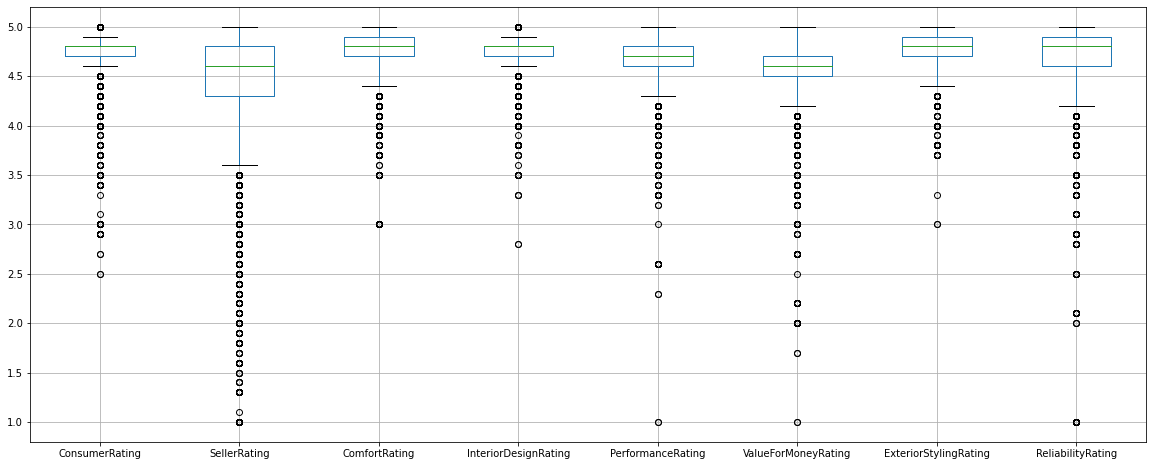

In [ ]:
num_rawdata[['ConsumerRating', 'SellerRating', 'ComfortRating', 'InteriorDesignRating', 'PerformanceRating', 
             'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating']].boxplot(figsize=(20, 8))

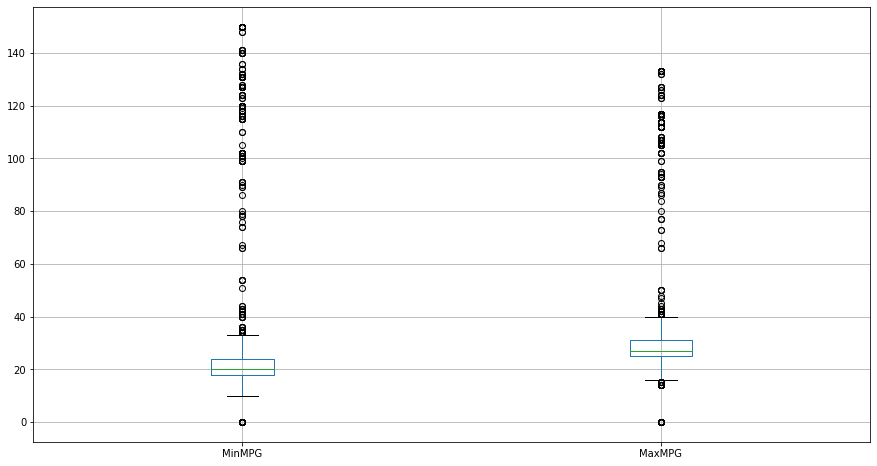

In [ ]:
num_rawdata[['MinMPG', 'MaxMPG']].boxplot(figsize=(15, 8))

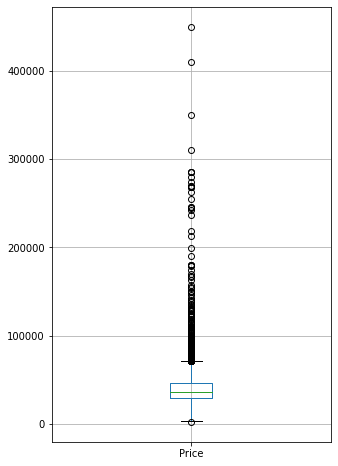

In [ ]:
num_rawdata.boxplot(column=['Price'], return_type='axes', figsize=(5, 8));

## Análisis Exploratorio

### Descripción de las Variables

In [ ]:
#rawdata.info() #si se quiere ver la cantidad de datos, el tipo de dato por columna, y el peso del archivo
print(rawdata[['SellerName', 'State', 'Make']].value_counts()[:5])# el vendedor que vendio mas vehiculos de una sola marca (el estado es info adicional)
print('\n')
rawdata[['Make', 'Model']].value_counts()[:5] # el modelo del vehiculo y la marca que mas se vendio

SellerName                        State  Make         
Principle Volvo Cars San Antonio  TX     Volvo            25
Autos of Dallas                   TX     BMW              18
Mercedes-Benz of Miami            FL     Mercedes-Benz    15
BMW of Alexandria                 VA     BMW              14
Toyota of Dallas                  TX     Toyota           14
dtype: int64




Make      Model                 
Jeep      Grand Cherokee Limited    266
Honda     CR-V EX-L                 189
BMW       X5 xDrive40i              164
Cadillac  XT5 Luxury                142
Toyota    RAV4 LE                   112
dtype: int64

In [ ]:
rawdata.describe() #Solo valores numericos

Year          Price  ConsumerRating  ConsumerReviews  \
count  9379.000000    9379.000000     9379.000000      9379.000000   
mean   2018.721719   39829.922806        4.702825       133.187014   
std       2.221708   20790.569384        0.240795       154.985640   
min    2001.000000    2300.000000        2.500000         1.000000   
25%    2018.000000   28993.500000        4.700000        30.000000   
50%    2019.000000   35999.000000        4.800000        75.000000   
75%    2020.000000   45997.000000        4.800000       182.000000   
max    2022.000000  449996.000000        5.000000       817.000000   

       SellerRating  SellerReviews  ComfortRating  InteriorDesignRating  \
count   9379.000000    9379.000000    9379.000000           9379.000000   
mean       4.412571     984.089988       4.771895              4.727391   
std        0.626258    1609.039864       0.217822              0.194391   
min        1.000000       1.000000       3.000000              2.800000   
25%        4.300000     112.000000       4.700000              4.700000   
50%        4.600000     542.000000       4.800000              4.800000   
75%        4.800000    1272.000000       4.900000              4.800000   
max        5.000000   27824.000000       5.000000              5.000000   

       PerformanceRating  ValueForMoneyRating  ExteriorStylingRating  \
count        9379.000000          9379.000000            9379.000000   
mean            4.696290             4.537083               4.782194   
std             0.253664             0.338098               0.171537   
min             1.000000             1.000000               3.000000   
25%             4.600000             4.500000               4.700000   
50%             4.700000             4.600000               4.800000   
75%             4.800000             4.700000               4.900000   
max             5.000000             5.000000               5.000000   

       ReliabilityRating       MinMPG       MaxMPG        Mileage  
count        9379.000000  9379.000000  9379.000000    9379.000000  
mean            4.681746    22.755411    29.216548   37463.023350  
std             0.368161    14.812869    12.809783   24970.342569  
min             1.000000     0.000000     0.000000     121.000000  
25%             4.600000    18.000000    25.000000   18666.500000  
50%             4.800000    20.000000    27.000000   32907.000000  
75%             4.900000    24.000000    31.000000   47698.000000  
max             5.000000   150.000000   133.000000  234114.000000

In [ ]:
rawdata.describe(include=['object']) #solo valores categoricos (object ya que ese es su datatype)

Make                   Model Used/New SellerType  \
count   9379                    9379     9379       9379   
unique    41                    1304        2          2   
top      BMW  Grand Cherokee Limited     Used     Dealer   
freq     944                     266     7900       9339   

                            SellerName                  StreetName State  \
count                             9379                        9379  9379   
unique                            3971                        3967    58   
top     EchoPark Automotive Greenville  2930 Laurens Rd Greenville    TX   
freq                                36                          36  1225   

       Zipcode DealType ExteriorColor InteriorColor       Drivetrain  \
count     9379     9157          9379          9379             9379   
unique    2163        3           949           374                9   
top      76051     Good         Black         Black  All-wheel Drive   
freq        69     5524           897          3758             4480   

        FuelType       Transmission                      Engine  \
count       9379               9379                        9379   
unique        13                 93                         326   
top     Gasoline  8-Speed Automatic  2.0L I4 16V GDI DOHC Turbo   
freq        8905               3202                        1629   

                      VIN Stock#  
count                9379   9379  
unique               8474   8431  
top     JHLRW2H8XKX023259      –  
freq                    3     40

In [ ]:
rawdata.nlargest(5, 'Price')[['Year', 'Make', 'Model', 'Used/New', 'Price', 'State']] #Los 5 vehiculos mas costosos

Year           Make              Model Used/New   Price  State
7943  2020  Mercedes-Benz      AMG G 63 Base     Used  449996     NC
2888  2017  Mercedes-Benz      G-Class G 550     Used  409999  Suite
1626  2013    Lamborghini  Aventador LP700-4     Used  349995     MO
2181  2022        Porsche            911 GT3     Used  309888     TX
2060  2020    Lamborghini          Urus Base     Used  285000     NJ

In [ ]:
rawdata.nsmallest(5, 'Price')[['Year', 'Make', 'Model', 'Used/New', 'Price', 'State']] #Los 5 vehiculos mas baratos

Year       Make             Model Used/New  Price State
2593  2006  Chevrolet         Impala LT     Used   2300    SC
811   2009       Ford          Focus SE     Used   3995    NY
6060  2004    Hyundai       Elantra GLS     Used   3995    SC
424   2003      Lexus  ES 300 Base (A5)     Used   3999    FL
1048  2015   Chrysler       200 Limited     Used   4250    TX

### Gráficas de Densidad

Gráfica de densidad de la variable Price:

(0.0, 449996.0)

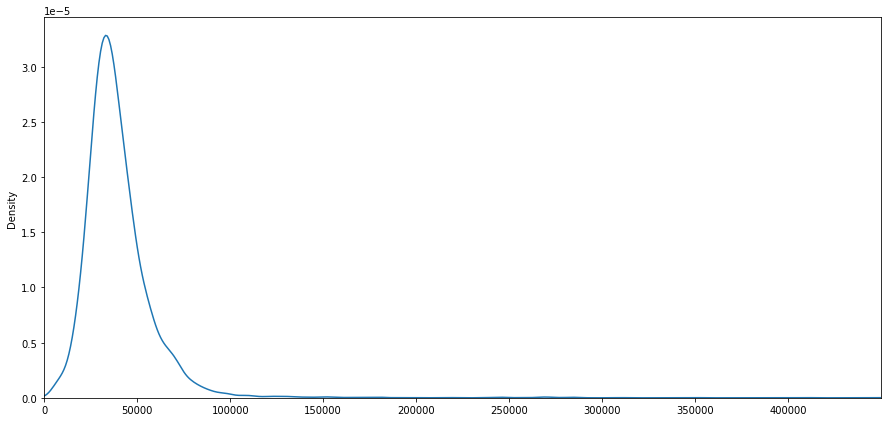

In [ ]:
rawdata[['Price']].plot.kde(figsize=(15,7), legend=False)
plt.ylim(0)
plt.xlim(0, np.max(rawdata['Price']))

### Histogramas

Se usa un histograma para mirar la cantidad de vehículos que se vendieron por concesionaria y por estado. De esto, se observa que los vehículos BMW fueron lo más vendidos mientras que vehículos como Ferraris fueron los menos vendidos. Mientras que, para los estados de USA, el estado de Texas fue donde más se vendieron vehículos y Alaska fue uno de los estados donde menos se vendió.

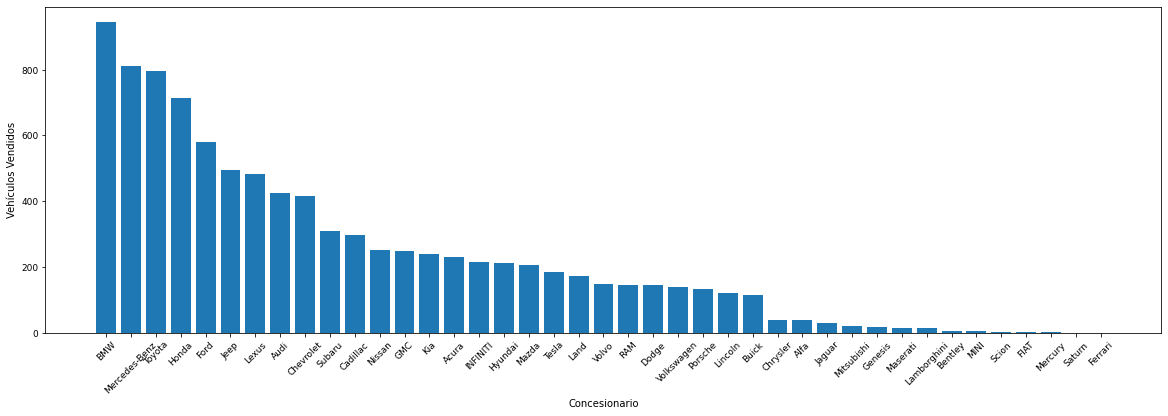

In [ ]:
drd = rawdata['Make'].value_counts().to_dict()
names = list(drd.keys())
values = list(drd.values())

fig, ax = plt.subplots(figsize=(20, 6))
plt.bar(range(len(drd)), values, tick_label=names)
plt.xticks(rotation = 45)
plt.xlabel('Concesionario', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

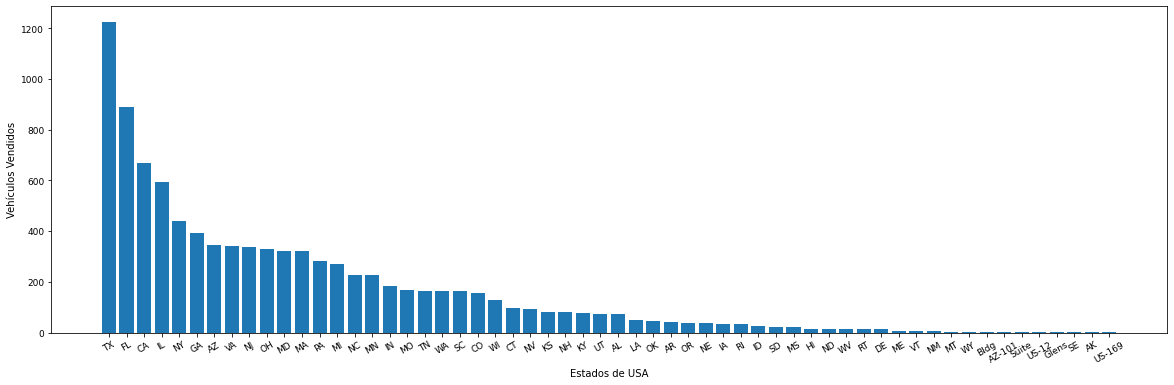

In [ ]:
drd = rawdata['State'].value_counts().to_dict()
names = list(drd.keys())
values = list(drd.values())

fig, ax = plt.subplots(figsize=(20, 6))
plt.bar(range(len(drd)), values, tick_label=names)
plt.xticks(rotation = 30)
plt.xlabel('Estados de USA', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

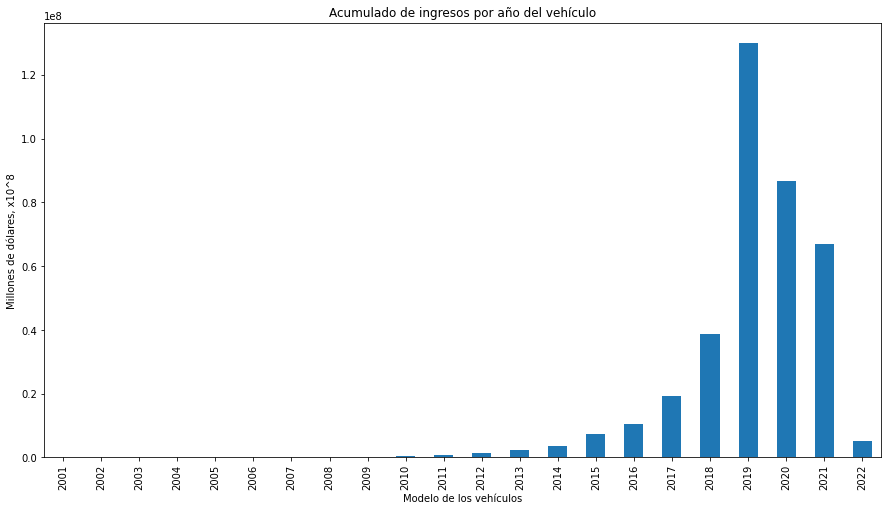

In [ ]:
rawdata.groupby('Year')['Price'].sum().plot.bar(figsize=(15, 8))
plt.title('Acumulado de ingresos por año del vehículo')
plt.xlabel('Modelo de los vehículos')
plt.ylabel('Millones de dólares, x10^8')
plt.show()

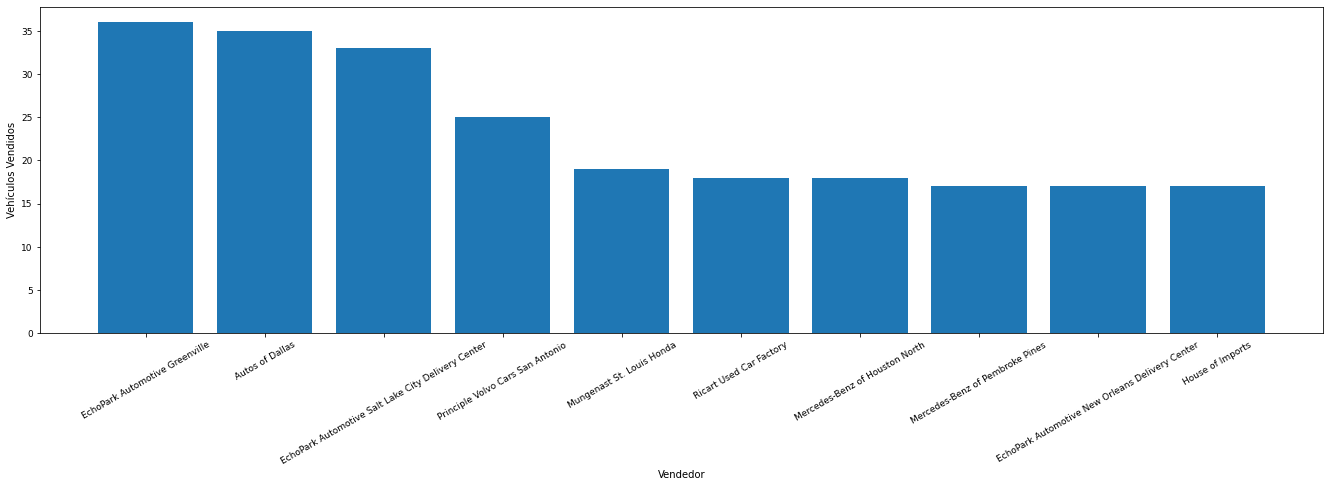

In [ ]:
drd = rawdata['SellerName'].value_counts()[:10].to_dict()
names = list(drd.keys())
values = list(drd.values())

fig, ax = plt.subplots(figsize=(23, 6))
plt.bar(range(len(drd)), values, tick_label=names)
plt.xticks(rotation = 30)
plt.xlabel('Vendedor', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

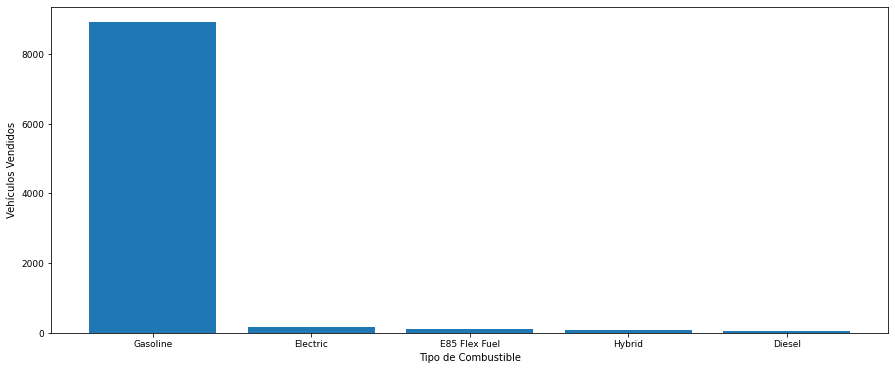

In [ ]:
drd = rawdata['FuelType'].value_counts()[:5].to_dict()
names = list(drd.keys())
values = list(drd.values())

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(drd)), values, tick_label=names)
plt.xlabel('Tipo de Combustible', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

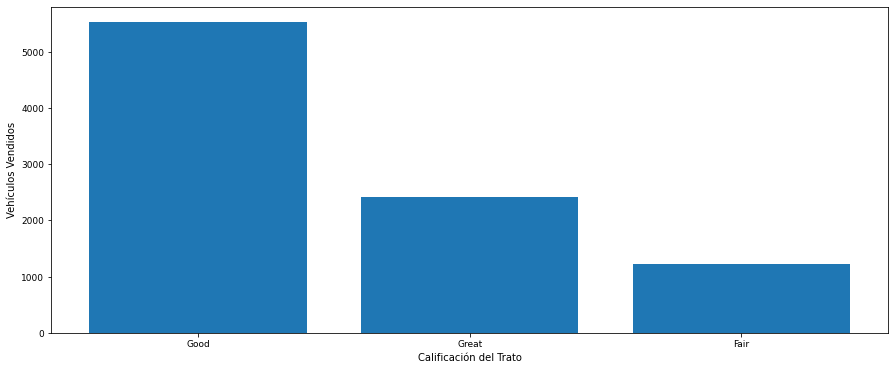

In [ ]:
drd = rawdata['DealType'].value_counts().to_dict()
names = list(drd.keys())
values = list(drd.values())

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(drd)), values, tick_label=names)
plt.xlabel('Calificación del Trato', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

## Preprocesamiento

### Eliminación de Duplicados

In [ ]:
print('Numero de registros antes de eliminar duplicados = %d' % (rawdata.shape[0]))
dataclean = rawdata.drop_duplicates()
print('Numero de registros despues de eliminar duplicados = %d' % (dataclean.shape[0]))

Numero de registros antes de eliminar duplicados = 9379
Numero de registros despues de eliminar duplicados = 8507


### Normalización

In [ ]:
numclean = dataclean[['Year', 'Price', 'ConsumerRating', 'ConsumerReviews', 'SellerRating', 'SellerReviews', 'ComfortRating', 'InteriorDesignRating',
                       'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating', 'MinMPG', 'MaxMPG', 'Mileage']]

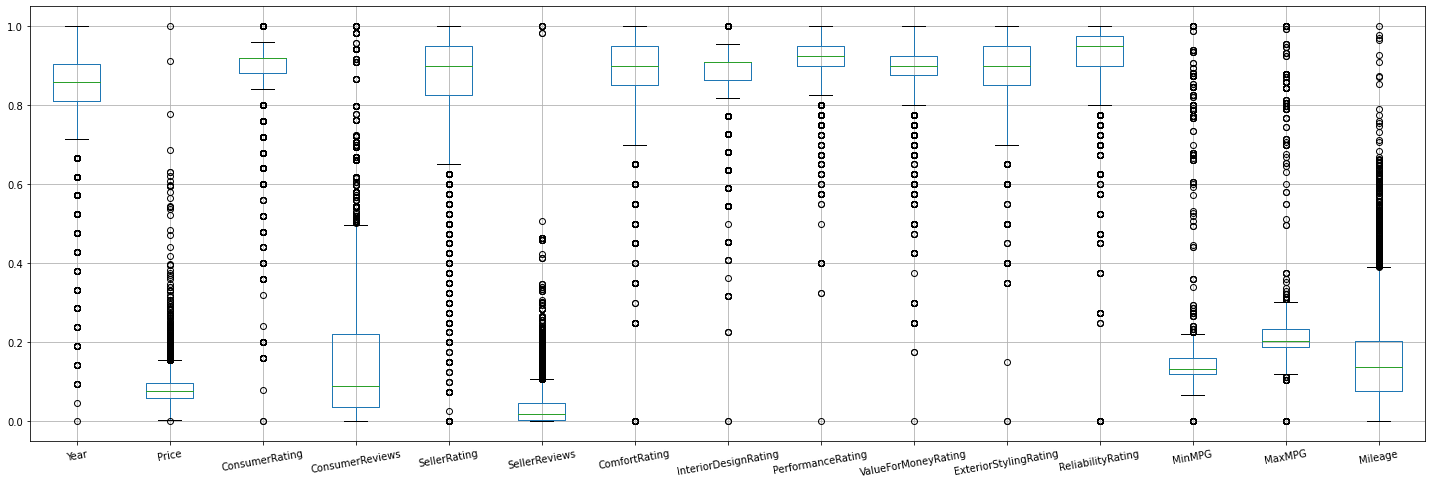

In [ ]:
numclean.apply(lambda x: (x-x.min())/(x.max()-x.min())).boxplot(figsize=(25, 8))
plt.xticks(rotation=10)
plt.show()

### Outliers usando medias y varianzas

In [ ]:
ndata = ['Year', 'Price', 'ConsumerRating', 'ConsumerReviews', 'SellerRating', 'SellerReviews', 'ComfortRating', 'InteriorDesignRating',
                       'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating', 'MinMPG', 'MaxMPG', 'Mileage']

def umbral(x, mean, var, num=2):
  if x >= (mean + num*var) or x <= (mean - num*var):
    return True
  else:
    return False

for data in ndata:
  out = numclean[data].apply(lambda x: umbral(x, numclean[data].mean(), numclean[data].var()))
  print('Para la variable {}, hay {} outliers por el método de media y dos desviaciones estandar'.format(data, out.sum()))

Para la variable Year, hay 60 outliers por el método de media y dos desviaciones estandar
Para la variable Price, hay 0 outliers por el método de media y dos desviaciones estandar
Para la variable ConsumerRating, hay 2499 outliers por el método de media y dos desviaciones estandar
Para la variable ConsumerReviews, hay 0 outliers por el método de media y dos desviaciones estandar
Para la variable SellerRating, hay 801 outliers por el método de media y dos desviaciones estandar
Para la variable SellerReviews, hay 0 outliers por el método de media y dos desviaciones estandar
Para la variable ComfortRating, hay 4464 outliers por el método de media y dos desviaciones estandar
Para la variable InteriorDesignRating, hay 3881 outliers por el método de media y dos desviaciones estandar
Para la variable PerformanceRating, hay 3160 outliers por el método de media y dos desviaciones estandar
Para la variable ValueForMoneyRating, hay 2612 outliers por el método de media y dos desviaciones estandar


In [ ]:
for data in ndata:
  out = numclean[data].apply(lambda x: umbral(x, numclean[data].mean(), numclean[data].std(), num=3))
  print('Para la variable {}, hay {} outliers por el método de media y tres desviaciones estandar'.format(data, out.sum()))

Para la variable Year, hay 196 outliers por el método de media y tres desviaciones estandar
Para la variable Price, hay 89 outliers por el método de media y tres desviaciones estandar
Para la variable ConsumerRating, hay 128 outliers por el método de media y tres desviaciones estandar
Para la variable ConsumerReviews, hay 147 outliers por el método de media y tres desviaciones estandar
Para la variable SellerRating, hay 235 outliers por el método de media y tres desviaciones estandar
Para la variable SellerReviews, hay 151 outliers por el método de media y tres desviaciones estandar
Para la variable ComfortRating, hay 203 outliers por el método de media y tres desviaciones estandar
Para la variable InteriorDesignRating, hay 175 outliers por el método de media y tres desviaciones estandar
Para la variable PerformanceRating, hay 105 outliers por el método de media y tres desviaciones estandar
Para la variable ValueForMoneyRating, hay 197 outliers por el método de media y tres desviacione

### Discretización Price

In [ ]:
lbl = ['Economico', 'Precio Justo', 'Costoso', 'Muy Costoso']
pricecut = pd.cut(numclean['Price'], 4)
priceqcut = pd.qcut(numclean['Price'], 4)
pc = numclean['Price'].copy()
pqc = numclean['Price'].copy()
pc['Price'] = pricecut.cat.codes
pqc['Price'] = priceqcut.cat.codes
pc = pc['Price'].apply(lambda x: lbl[x])
pqc = pqc['Price'].apply(lambda x: lbl[x])

In [ ]:
pricecut

0       (1852.304, 114224.0]
1       (1852.304, 114224.0]
2       (1852.304, 114224.0]
3       (1852.304, 114224.0]
4       (1852.304, 114224.0]
                ...         
9373    (1852.304, 114224.0]
9374    (1852.304, 114224.0]
9376    (1852.304, 114224.0]
9377    (1852.304, 114224.0]
9378    (1852.304, 114224.0]
Name: Price, Length: 8507, dtype: category
Categories (4, interval[float64, right]): [(1852.304, 114224.0] < (114224.0, 226148.0] <
                                           (226148.0, 338072.0] < (338072.0, 449996.0]]

In [ ]:
priceqcut

0        (36190.0, 45998.5]
1       (45998.5, 449996.0]
2        (36190.0, 45998.5]
3       (2299.999, 28994.0]
4       (45998.5, 449996.0]
               ...         
9373     (28994.0, 36190.0]
9374    (2299.999, 28994.0]
9376    (2299.999, 28994.0]
9377    (2299.999, 28994.0]
9378     (28994.0, 36190.0]
Name: Price, Length: 8507, dtype: category
Categories (4, interval[float64, right]): [(2299.999, 28994.0] < (28994.0, 36190.0] <
                                           (36190.0, 45998.5] < (45998.5, 449996.0]]

In [ ]:
pc.value_counts(), pqc.value_counts()

(Economico       8441
 Precio Justo      47
 Costoso           16
 Muy Costoso        3
 dtype: int64, Economico       2129
 Muy Costoso     2127
 Costoso         2126
 Precio Justo    2125
 dtype: int64)

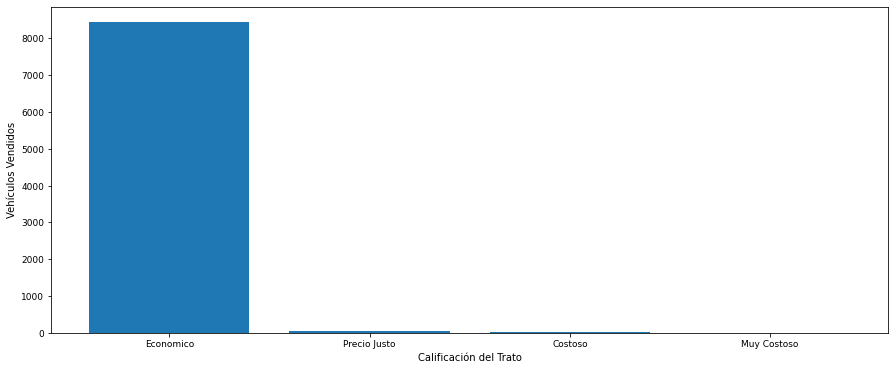

In [ ]:
pcd = pc.value_counts().to_dict()
names = list(pcd.keys())
values = list(pcd.values())

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(pcd)), values, tick_label=names)
plt.xlabel('Calificación del Trato', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

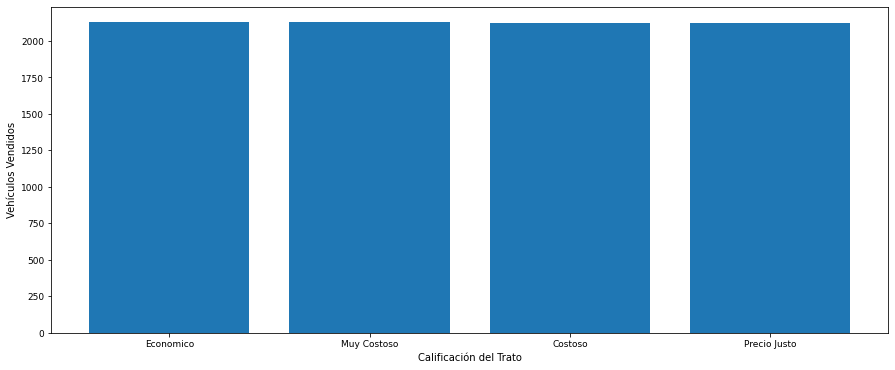

In [ ]:
pqcd = pqc.value_counts().to_dict()
names = list(pqcd.keys())
values = list(pqcd.values())

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(pqcd)), values, tick_label=names)
plt.xlabel('Calificación del Trato', fontsize=10)
plt.ylabel('Vehículos Vendidos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

### Discretización Mileage

In [ ]:
mileagecut, binmc = pd.cut(numclean['Mileage'], 5, retbins=True)
mileageqcut, binmqc = pd.qcut(numclean['Mileage'], 5, retbins=True)
mc = numclean['Mileage'].copy()
mqc = numclean['Mileage'].copy()
mc['Mileage'] = mileagecut.cat.codes
mqc['Mileage'] = mileageqcut.cat.codes
binmc = [i if i>= 0 else 0 for i in binmc]
binmqc = [i if i>= 0 else 0 for i in binmqc]
lblmc = ['({} - {}]'.format(np.round(binmc[i], 2), np.round(binmc[i+1], 2)) for i in range(len(binmc)-1)]
lblmqc = ['({} - {}]'.format(np.round(binmqc[i], 2), np.round(binmqc[i+1], 2)) for i in range(len(binmqc)-1)]
mc = mc['Mileage'].apply(lambda x: lblmc[x])
mqc = mqc['Mileage'].apply(lambda x: lblmqc[x])

In [ ]:
mc.value_counts(), mqc.value_counts()

((0 - 46919.6]            6266
 (46919.6 - 93718.2]      1984
 (93718.2 - 140516.8]      198
 (140516.8 - 187315.4]      50
 (187315.4 - 234114.0]       9
 dtype: int64, (16729.8 - 24368.0]     1703
 (121.0 - 16729.8]       1702
 (49995.4 - 234114.0]    1702
 (37613.6 - 49995.4]     1701
 (24368.0 - 37613.6]     1699
 dtype: int64)

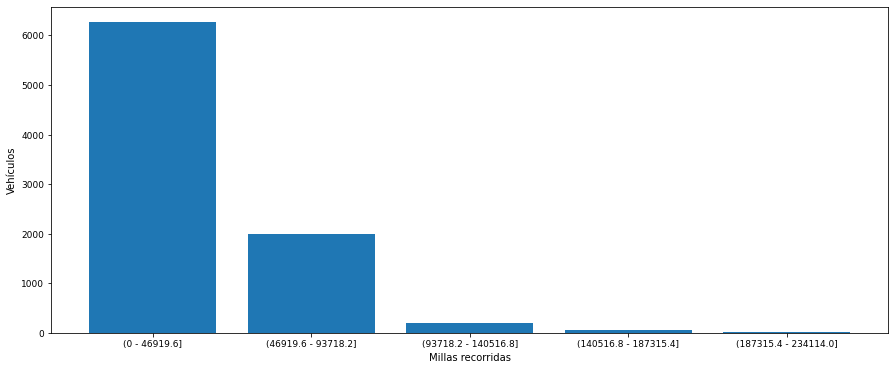

In [ ]:
mcd = mc.value_counts().to_dict()
values = [mcd[i] for i in lblmc]

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(mcd)), values, tick_label=lblmc)
plt.xlabel('Millas recorridas', fontsize=10)
plt.ylabel('Vehículos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

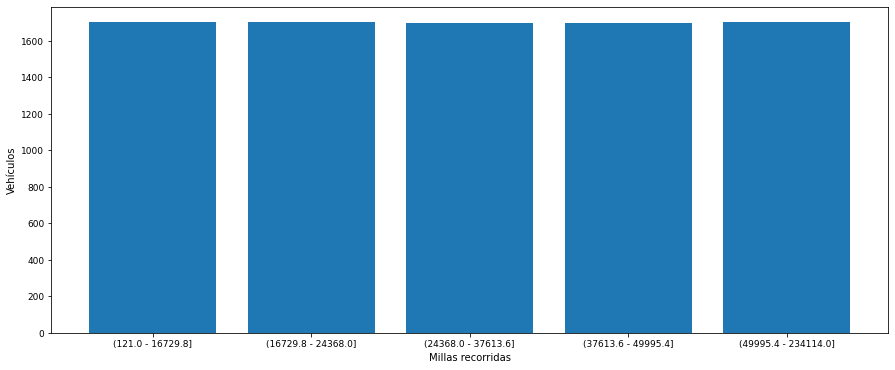

In [ ]:
mqcd = mqc.value_counts().to_dict()
values = [mqcd[i] for i in lblmqc]

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(range(len(mqcd)), values, tick_label=lblmqc)
plt.xlabel('Millas recorridas', fontsize=10)
plt.ylabel('Vehículos', fontsize=10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)
plt.show()

### Ranking por medias y varianzas (variables numéricas)

In [ ]:
num_rawdata["DealType"] = rawdata["DealType"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rankingbasepd = num_rawdata.dropna()
rankingbasenp = rankingbasepd.to_numpy()

In [ ]:
E = rankingbasenp[:,:-1]
ind = rankingbasenp[:,-1]

ind_gr = ind=='Great'
ind_go = ind=='Good'
ind_fa = ind=='Fair'

E_0 = E[ind_gr]
E_1 = E[ind_go]
E_2 = E[ind_fa]

In [ ]:
testvals = np.zeros(E.shape[1])

for i in range(E.shape[1]):
    SE = np.sqrt( np.var(E_0[:,i])/E_0.shape[0] + np.var(E_1[:,i])/E_1.shape[0] + np.var(E_2[:,i])/E_2.shape[0] )
    means = [np.mean(E_0[:,i]), np.mean(E_1[:,i]), np.mean(E_2[:,i])]
    testvals[i] = (np.max(means)-np.min(means)) / SE

varorder = np.argsort(testvals)

print(f"Los coeficientes de las variables son {dict(zip(rankingbasepd.columns, np.round(testvals, 4)))}")
print(f"El ranking de las dimensiones según las medias y varianzas (en orden ascendente) es {[rankingbasepd.columns[i] for i in varorder]}.")

Los coeficientes de las variables son {'Year': 11.4196, 'Price': 9.9261, 'ConsumerRating': 1.7963, 'ConsumerReviews': 7.3178, 'SellerRating': 3.1371, 'SellerReviews': 1.56, 'ComfortRating': 0.8854, 'InteriorDesignRating': 1.6531, 'PerformanceRating': 3.1947, 'ValueForMoneyRating': 4.3602, 'ExteriorStylingRating': 1.2274, 'ReliabilityRating': 2.0202, 'MinMPG': 4.4763, 'MaxMPG': 3.9029, 'Mileage': 9.9958}
El ranking de las dimensiones según las medias y varianzas (en orden ascendente) es ['ComfortRating', 'ExteriorStylingRating', 'SellerReviews', 'InteriorDesignRating', 'ConsumerRating', 'ReliabilityRating', 'SellerRating', 'PerformanceRating', 'MaxMPG', 'ValueForMoneyRating', 'MinMPG', 'ConsumerReviews', 'Price', 'Mileage', 'Year'].


### Análisis de Componentes Principales (PCA)

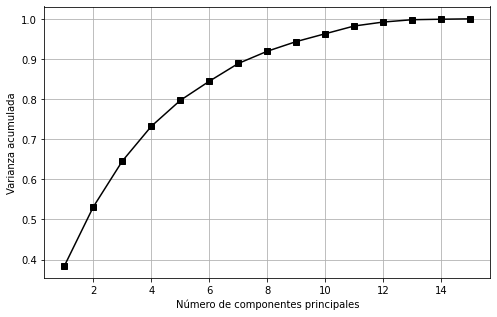

In [ ]:
scalar = StandardScaler()
ndata_scaled = pd.DataFrame(scalar.fit_transform(numclean), columns=numclean.columns)

pca = PCA()
numd_pca = pd.DataFrame(pca.fit_transform(ndata_scaled))

numpca = pca.explained_variance_ratio_
plt.figure(figsize = (8,5))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')

cum_var_exp = np.cumsum(numpca)
nc = np.arange(1, numpca.shape[0] + 1)
plt.plot(nc, cum_var_exp, '-ks')
plt.grid()


In [ ]:
comps = np.round(pca.components_, 3)

print(f"Los componentes principales obtenidos son:")
for comp in comps:
    print(f"- {[ str(comp[i])+'*'+numclean.columns[i] for i in range(len(comp)) ]}")

Los componentes principales obtenidos son:
- ['-0.051*Year', '0.041*Price', '-0.408*ConsumerRating', '-0.032*ConsumerReviews', '-0.022*SellerRating', '-0.021*SellerReviews', '-0.371*ComfortRating', '-0.347*InteriorDesignRating', '-0.32*PerformanceRating', '-0.373*ValueForMoneyRating', '-0.354*ExteriorStylingRating', '-0.366*ReliabilityRating', '0.191*MinMPG', '0.178*MaxMPG', '0.029*Mileage']
- ['-0.524*Year', '-0.383*Price', '-0.021*ConsumerRating', '0.22*ConsumerReviews', '-0.102*SellerRating', '-0.065*SellerReviews', '-0.018*ComfortRating', '-0.126*InteriorDesignRating', '-0.158*PerformanceRating', '0.047*ValueForMoneyRating', '-0.051*ExteriorStylingRating', '0.044*ReliabilityRating', '-0.322*MinMPG', '-0.308*MaxMPG', '0.518*Mileage']
- ['0.16*Year', '0.349*Price', '-0.105*ConsumerRating', '-0.245*ConsumerReviews', '0.075*SellerRating', '0.008*SellerReviews', '-0.005*ComfortRating', '0.031*InteriorDesignRating', '-0.196*PerformanceRating', '-0.18*ValueForMoneyRating', '0.054*Exterior

###Analisis Correspondencia Multiple (MCA)

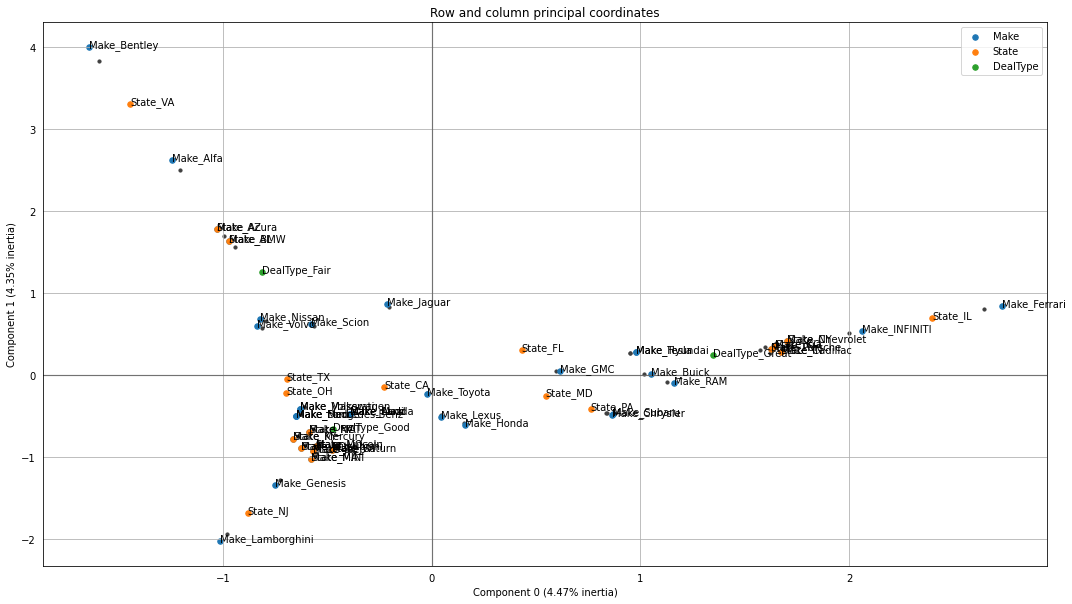

In [ ]:
data_sample = dataclean.groupby('Make', group_keys=False).apply(lambda dataclean: dataclean.sample(1))
catclean_sample = data_sample[['Make', 'State', 'DealType']]

mca = prince.MCA()
mca.fit(catclean_sample)

mca.plot_coordinates(catclean_sample, row_points_alpha=1, figsize=(18, 10), show_column_labels=True);

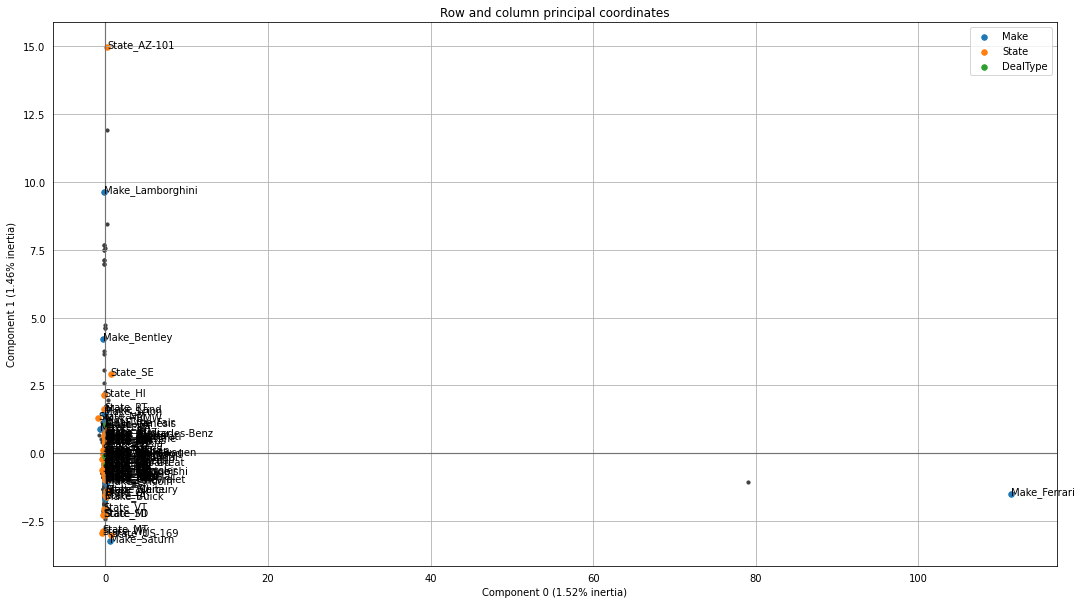

In [ ]:
catclean = dataclean[['Make', 'State', 'DealType']]

mca = prince.MCA()
mca.fit(catclean)

mca.plot_coordinates(catclean, row_points_alpha=1, figsize=(18, 10), show_column_labels=True);

## Nuevas Variables

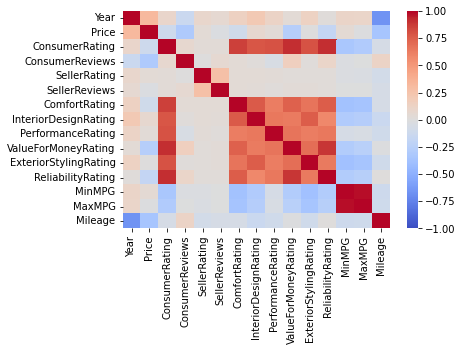

In [ ]:
sns.heatmap(dataclean.corr(), vmin=-1, vmax=+1, annot=False, cmap = 'coolwarm')

Al revisar las correlaciones que hay entre las variables, se opta por crear una nuerva variable 'CarRating', siendo el ponderado de los ratings del vehículo, ya que estas variables muestran una gran correlación. Posteriormente, se mira la correlación entre esta nueva variable CarRating con Price y ConsumerRating.

In [ ]:
dataclean['CarRating'] = (dataclean['ComfortRating'] + dataclean['InteriorDesignRating'] + dataclean['PerformanceRating'] + 
                        dataclean['ValueForMoneyRating'] + dataclean['ExteriorStylingRating'] + dataclean['ReliabilityRating'])/6

dataclean[['Price', 'ConsumerRating', 'CarRating']].corr()

<ipython-input-18-d8d70683bf31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataclean['CarRating'] = (dataclean['ComfortRating'] + dataclean['InteriorDesignRating'] + dataclean['PerformanceRating'] +


Price  ConsumerRating  CarRating
Price           1.000000       -0.110179  -0.112104
ConsumerRating -0.110179        1.000000   0.988940
CarRating      -0.112104        0.988940   1.000000

Se ve poca correlación entre los ratings y la variable price, pero, la correlación es alta entre los ratings. 

Luego, se observa las distribuciones de los ratings y el precio.

(0.0, 7.0)

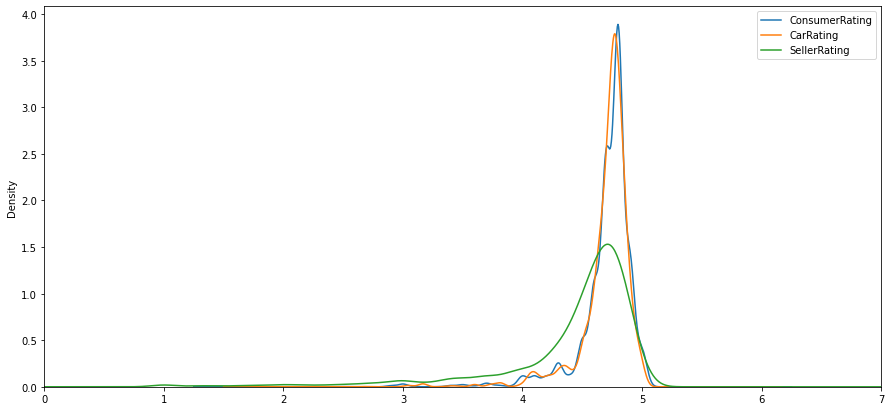

In [ ]:
dataclean[['ConsumerRating', 'CarRating', 'SellerRating']].plot.kde(figsize=(15,7))
plt.ylim(0)
plt.xlim(0, 7)

In [ ]:
dataclean['CarRating'].describe()

count    8507.000000
mean        4.698783
std         0.224466
min         2.666667
25%         4.650000
50%         4.750000
75%         4.816667
max         5.000000
Name: CarRating, dtype: float64

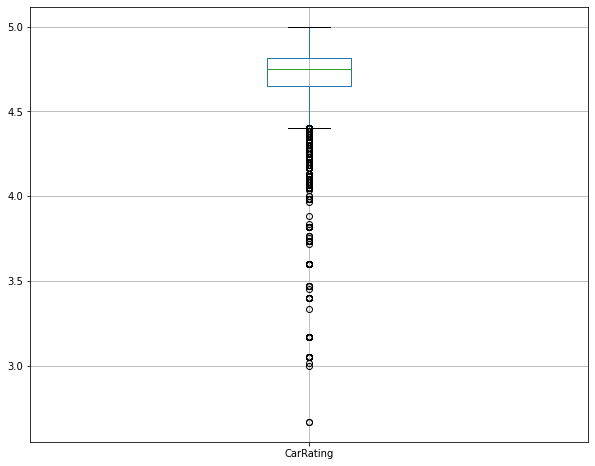

In [ ]:
dataclean[['CarRating']].boxplot(figsize=(10,8))

Finalmente, se observa la relaciones entre las variables Price, CarRating y ConsumerRating discretizado por la concesionaria.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


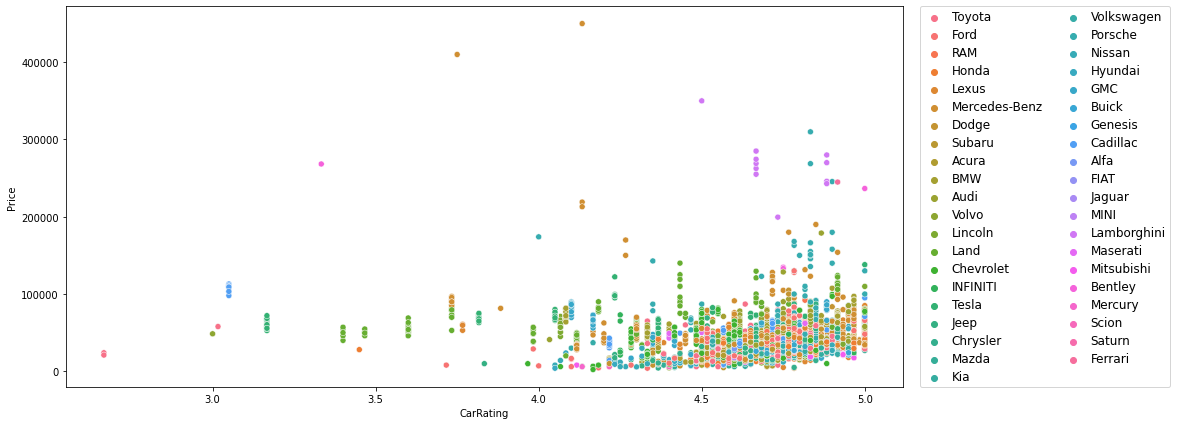

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot('CarRating', 'Price', data=dataclean, hue='Make')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


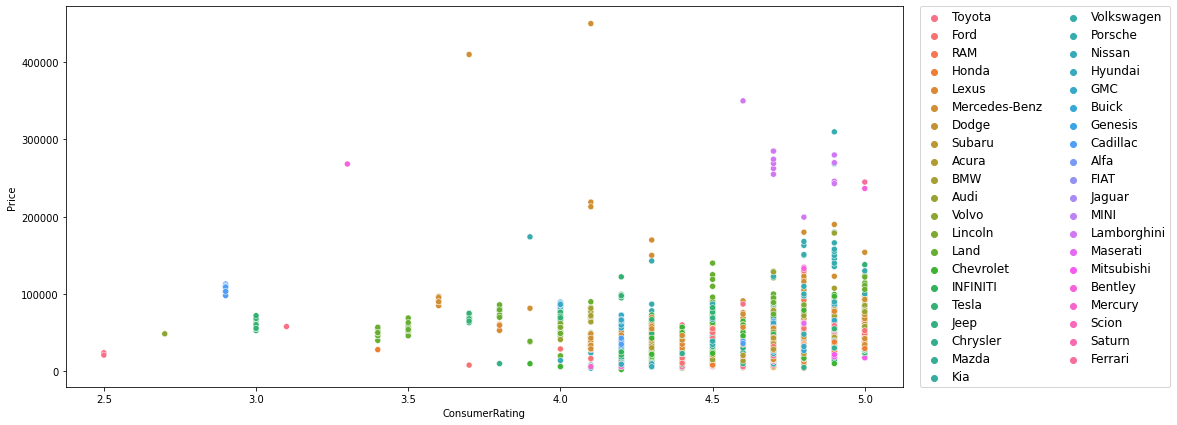

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot('ConsumerRating', 'Price', data=dataclean, hue='Make')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


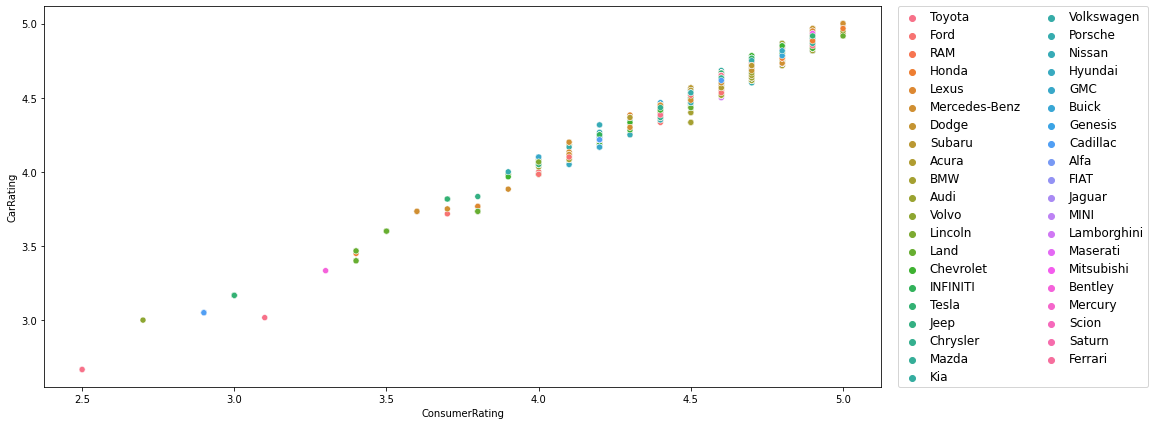

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot('ConsumerRating', 'CarRating', data=dataclean, hue='Make')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.show()

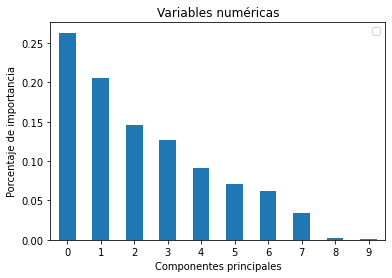

In [ ]:
numdataclean = dataclean[['Year', 'Price', 'ConsumerRating', 'ConsumerReviews', 'SellerRating', 'SellerReviews', 'MinMPG', 'MaxMPG', 'Mileage', 'CarRating']]

scalar = StandardScaler()
ndata_scaled = pd.DataFrame(scalar.fit_transform(numdataclean), columns=numdataclean.columns)

pca = PCA()
numd_pca = pd.DataFrame(pca.fit_transform(ndata_scaled))

numpca = pd.DataFrame(pca.explained_variance_ratio_)
numpca.plot.bar()
plt.legend('')
plt.title('Variables numéricas')
plt.xlabel('Componentes principales')
plt.xticks(rotation=0)
plt.ylabel('Porcentaje de importancia');

## Reglas de Asociación

In [ ]:
!pip install efficient-apriori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fpgrowth-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Make-Year-Price

In [ ]:
marcas = dataclean[["Make","Year","Price"]]
discret, bins = pd.qcut(marcas.iloc[:,2], 16, labels=['P'+str(i) for i in range(16)], retbins=True)

marcas.iloc[:,2] = discret
for i in range(8507):
    marcas.iloc[i,1] = 'Y' + str(marcas.iloc[i,1]) 
marcas

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Make   Year Price
0      Toyota  Y2019    P9
1        Ford  Y2018   P12
2         RAM  Y2017   P10
3       Honda  Y2021    P3
4       Lexus  Y2020   P12
...       ...    ...   ...
9373    Honda  Y2019    P5
9374   Subaru  Y2019    P3
9376    Buick  Y2017    P3
9377   Subaru  Y2019    P3
9378  Hyundai  Y2019    P5

[8507 rows x 3 columns]

In [ ]:
for i in range(len(bins)-1):
    print("P_"+str(i),': [',int(bins[i]),'-',int(bins[i+1]),']')

P_0 : [ 2300 - 19983 ]
P_1 : [ 19983 - 23998 ]
P_2 : [ 23998 - 26922 ]
P_3 : [ 26922 - 28994 ]
P_4 : [ 28994 - 30774 ]
P_5 : [ 30774 - 32828 ]
P_6 : [ 32828 - 34566 ]
P_7 : [ 34566 - 36190 ]
P_8 : [ 36190 - 38453 ]
P_9 : [ 38453 - 40497 ]
P_10 : [ 40497 - 42998 ]
P_11 : [ 42998 - 45998 ]
P_12 : [ 45998 - 49998 ]
P_13 : [ 49998 - 56195 ]
P_14 : [ 56195 - 66900 ]
P_15 : [ 66900 - 449996 ]


In [ ]:
from efficient_apriori import apriori

itemsets, rules = apriori(marcas.iloc, min_support=5/8507, min_confidence=0.8)
for rule in sorted(rules, key=lambda rule: -rule.confidence):
  print(rule)

{Lamborghini} -> {P15} (conf: 1.000, supp: 0.001, lift: 16.051, conv: 937698366.051)
{Y2004} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{Y2006} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{BMW, Y2011} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{BMW, Y2013} -> {P0} (conf: 1.000, supp: 0.002, lift: 15.991, conv: 937463265.546)
{Cadillac, P11} -> {Y2019} (conf: 1.000, supp: 0.001, lift: 2.917, conv: 657223463.030)
{Ford, Y2012} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{Ford, Y2013} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{Lamborghini, Y2020} -> {P15} (conf: 1.000, supp: 0.001, lift: 16.051, conv: 937698366.051)
{Lincoln, Y2013} -> {P0} (conf: 1.000, supp: 0.001, lift: 15.991, conv: 937463265.546)
{Lincoln, P5} -> {Y2019} (conf: 1.000, supp: 0.001, lift: 2.917, conv: 657223463.030)
{Lincoln, P6} -> {Y2019} (conf: 1.000, supp: 0.001, lift: 2.917, conv: 6

In [ ]:
from fpgrowth_py import fpgrowth

freqItemSet, rules = fpgrowth(list(marcas.iloc), minSupRatio=5/8507, minConf=0.8)

for rule in sorted(rules, key=lambda rule: -rule[-1]):
    print(rule[0], "->", rule[1], "| conf =", np.round(rule[2],3))

{'Y2004'} -> {'P0'} | conf = 1.0
{'Y2006'} -> {'P0'} | conf = 1.0
{'Y2020', 'Lamborghini'} -> {'P15'} | conf = 1.0
{'Lamborghini'} -> {'P15'} | conf = 1.0
{'Mitsubishi', 'P1'} -> {'Y2020'} | conf = 1.0
{'BMW', 'Y2011'} -> {'P0'} | conf = 1.0
{'Y2012', 'Ford'} -> {'P0'} | conf = 1.0
{'Ford', 'Y2013'} -> {'P0'} | conf = 1.0
{'Lincoln', 'Y2013'} -> {'P0'} | conf = 1.0
{'BMW', 'Y2013'} -> {'P0'} | conf = 1.0
{'P5', 'Lincoln'} -> {'Y2019'} | conf = 1.0
{'P6', 'Lincoln'} -> {'Y2019'} | conf = 1.0
{'P12', 'Volkswagen'} -> {'Y2021'} | conf = 1.0
{'P11', 'Cadillac'} -> {'Y2019'} | conf = 1.0
{'GMC', 'P15'} -> {'Y2021'} | conf = 0.944
{'INFINITI', 'P7'} -> {'Y2019'} | conf = 0.926
{'Y2007'} -> {'P0'} | conf = 0.917
{'P5', 'Honda'} -> {'Y2019'} | conf = 0.903
{'Y2005'} -> {'P0'} | conf = 0.9
{'Land', 'Y2021'} -> {'P15'} | conf = 0.9
{'Y2009'} -> {'P0'} | conf = 0.889
{'Y2021', 'Porsche'} -> {'P15'} | conf = 0.882
{'P8', 'Cadillac'} -> {'Y2019'} | conf = 0.878
{'Dodge', 'P13'} -> {'Y2021'} | conf 

###Variables Categóricas

In [ ]:
categs = dataclean.select_dtypes(include='object')
categs.describe()

Make                   Model Used/New SellerType  \
count   8507                    8507     8507       8507   
unique    41                    1304        2          2   
top      BMW  Grand Cherokee Limited     Used     Dealer   
freq     844                     243     7182       8467   

                            SellerName                  StreetName State  \
count                             8507                        8507  8507   
unique                            3971                        3967    58   
top     EchoPark Automotive Greenville  2930 Laurens Rd Greenville    TX   
freq                                33                          33  1111   

       Zipcode DealType ExteriorColor InteriorColor       Drivetrain  \
count     8507     8301          8507          8507             8507   
unique    2163        3           949           374                9   
top      76051     Good         Black         Black  All-wheel Drive   
freq        63     5019           812          3404             4018   

        FuelType       Transmission                      Engine  \
count       8507               8507                        8507   
unique        13                 93                         326   
top     Gasoline  8-Speed Automatic  2.0L I4 16V GDI DOHC Turbo   
freq        8072               2889                        1478   

                      VIN Stock#  
count                8507   8507  
unique               8474   8431  
top     KM8J33A20HU377912      –  
freq                    2     40

In [ ]:
categs = dataclean[["Make","State","DealType","Drivetrain","Mileage","Price","Year","CarRating"]]

discretp = pd.qcut(categs.iloc[:,-3], 16, labels=['P'+str(i) for i in range(16)])
discretm = pd.qcut(categs.iloc[:,-4], 5, labels=['M'+str(i) for i in range(1,6)])

categs.iloc[:,-3] = discretp
categs.iloc[:,-4] = discretm

for i in range(8507):
    categs.iloc[i,-2] = 'Y' + str(categs.iloc[i,-2]) 
    categs.iloc[i,-1] = 'R' + str(np.round(categs.iloc[i,-1], 1)) 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
categs.drop(categs[categs['State'].str.len() > 2].index, inplace=True)
categs.drop(categs[categs['State'] == "RT"].index, inplace=True)
categs.drop(categs[categs['State'] == "SE"].index, inplace=True)

categs.dropna(inplace=True)

categs.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Make State DealType       Drivetrain Mileage Price   Year CarRating
count   8283  8283     8283             8283    8283  8283   8283      8283
unique    40    50        3                9       5    16     20        21
top      BMW    TX     Good  All-wheel Drive      M3   P10  Y2019      R4.8
freq     823  1095     5006             3911    1672   533   2879      3175

In [ ]:
print("UNIQUE MAKES")
print(np.unique(categs["Make"]))
print("\nUNIQUE DRIVETRAINS")
print(np.unique(categs["Drivetrain"]))

UNIQUE MAKES
['Acura' 'Alfa' 'Audi' 'BMW' 'Bentley' 'Buick' 'Cadillac' 'Chevrolet'
 'Chrysler' 'Dodge' 'FIAT' 'Ford' 'GMC' 'Genesis' 'Honda' 'Hyundai'
 'INFINITI' 'Jaguar' 'Jeep' 'Kia' 'Lamborghini' 'Land' 'Lexus' 'Lincoln'
 'MINI' 'Maserati' 'Mazda' 'Mercedes-Benz' 'Mercury' 'Mitsubishi' 'Nissan'
 'Porsche' 'RAM' 'Saturn' 'Scion' 'Subaru' 'Tesla' 'Toyota' 'Volkswagen'
 'Volvo']

UNIQUE DRIVETRAINS
['4WD' 'AWD' 'All-wheel Drive' 'FWD' 'Four-wheel Drive'
 'Front Wheel Drive' 'Front-wheel Drive' 'RWD' 'Rear-wheel Drive']


In [ ]:
itemsets, rules = apriori(categs.iloc, min_support=0.01, min_confidence=0.8)
for rule in sorted(rules, key=lambda rule: -rule.confidence):
  print(rule)

{Subaru, Y2019} -> {All-wheel Drive} (conf: 1.000, supp: 0.015, lift: 2.118, conv: 527828081.613)
{Good, R4.7, Subaru} -> {All-wheel Drive} (conf: 1.000, supp: 0.015, lift: 2.118, conv: 527828081.613)
{Good, Subaru, Y2019} -> {All-wheel Drive} (conf: 1.000, supp: 0.011, lift: 2.118, conv: 527828081.613)
{R4.7, Subaru, Y2019} -> {All-wheel Drive} (conf: 1.000, supp: 0.013, lift: 2.118, conv: 527828081.613)
{Good, R4.7, Subaru, Y2019} -> {All-wheel Drive} (conf: 1.000, supp: 0.010, lift: 2.118, conv: 527828081.613)
{Good, Subaru} -> {All-wheel Drive} (conf: 0.994, supp: 0.021, lift: 2.106, conv: 93.426)
{R4.7, Subaru} -> {All-wheel Drive} (conf: 0.994, supp: 0.020, lift: 2.105, conv: 86.036)
{Audi, M1} -> {All-wheel Drive} (conf: 0.989, supp: 0.011, lift: 2.095, conv: 49.088)
{Subaru} -> {All-wheel Drive} (conf: 0.989, supp: 0.031, lift: 2.094, conv: 46.097)
{Honda, P5, Y2019} -> {R4.8} (conf: 0.988, supp: 0.010, lift: 2.578, conv: 51.802)
{P15, Tesla} -> {All-wheel Drive} (conf: 0.978, 

In [ ]:
freqItemSet, rules = fpgrowth(list(categs.iloc), minSupRatio=0.01, minConf=0.8)

for rule in sorted(rules, key=lambda rule: -rule[-1]):
    print(rule[0], "->", rule[1], "| conf =", np.round(rule[2],3))

{'Subaru', 'R4.7', 'Good', 'Y2019'} -> {'All-wheel Drive'} | conf = 1.0
{'Subaru', 'Good', 'Y2019'} -> {'All-wheel Drive'} | conf = 1.0
{'Subaru', 'R4.7', 'Y2019'} -> {'All-wheel Drive'} | conf = 1.0
{'Subaru', 'Y2019'} -> {'All-wheel Drive'} | conf = 1.0
{'Subaru', 'R4.7', 'Good'} -> {'All-wheel Drive'} | conf = 1.0
{'Subaru', 'Good'} -> {'All-wheel Drive'} | conf = 0.994
{'Subaru', 'R4.7'} -> {'All-wheel Drive'} | conf = 0.994
{'M1', 'Audi'} -> {'All-wheel Drive'} | conf = 0.989
{'Subaru'} -> {'All-wheel Drive'} | conf = 0.989
{'P5', 'Honda', 'Y2019'} -> {'R4.8'} | conf = 0.988
{'Tesla', 'P15'} -> {'All-wheel Drive'} | conf = 0.978
{'BMW', 'R4.8', 'Y2019'} -> {'All-wheel Drive'} | conf = 0.973
{'R4.7', 'Audi'} -> {'All-wheel Drive'} | conf = 0.973
{'Y2019', 'Audi'} -> {'All-wheel Drive'} | conf = 0.961
{'Audi'} -> {'All-wheel Drive'} | conf = 0.956
{'Good', 'Y2019', 'Audi'} -> {'All-wheel Drive'} | conf = 0.956
{'P5', 'Honda'} -> {'R4.8'} | conf = 0.946
{'All-wheel Drive', 'Honda', '

##Agrupamiento (Clustering)

In [ ]:
physicdata = dataclean[["Year", "Price", "Mileage", "MinMPG", "MaxMPG", "CarRating", "ConsumerRating", "SellerRating"]]
physicdata

Year  Price  Mileage  MinMPG  MaxMPG  CarRating  ConsumerRating  \
0     2019  39998    29403      19      27   4.600000             4.6   
1     2018  49985    32929      19      24   4.766667             4.8   
2     2017  41860    23173      15      21   4.733333             4.7   
3     2021  28500    10598      29      35   4.966667             5.0   
4     2020  49000    28137      20      27   4.816667             4.8   
...    ...    ...      ...     ...     ...        ...             ...   
9373  2019  31999    44481      27      33   4.766667             4.8   
9374  2019  27374    15606      27      33   4.716667             4.7   
9376  2017  26944    62649      15      22   4.783333             4.8   
9377  2019  28568    30760      26      33   4.716667             4.7   
9378  2019  32091    41645      21      27   4.816667             4.8   

      SellerRating  
0              3.3  
1              4.8  
2              4.6  
3              4.6  
4              4.8  
...            ...  
9373           4.8  
9374           4.4  
9376           4.7  
9377           4.4  
9378           4.4  

[8507 rows x 8 columns]

In [ ]:
physicdatanorm = MinMaxScaler().fit_transform(physicdata)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(physicdatanorm)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8507 samples in 0.008s...
[t-SNE] Computed neighbors for 8507 samples in 1.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8507
[t-SNE] Computed conditional probabilities for sample 2000 / 8507
[t-SNE] Computed conditional probabilities for sample 3000 / 8507
[t-SNE] Computed conditional probabilities for sample 4000 / 8507
[t-SNE] Computed conditional probabilities for sample 5000 / 8507
[t-SNE] Computed conditional probabilities for sample 6000 / 8507
[t-SNE] Computed conditional probabilities for sample 7000 / 8507
[t-SNE] Computed conditional probabilities for sample 8000 / 8507
[t-SNE] Computed conditional probabilities for sample 8507 / 8507
[t-SNE] Mean sigma: 0.030797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.913887
[t-SNE] KL divergence after 1000 iterations: 1.239213


###K-Means

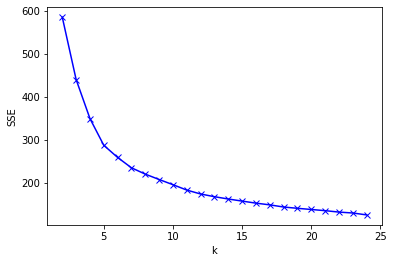

In [ ]:
Sum_of_squared_distances = []
K = range(2,25)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(physicdatanorm)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

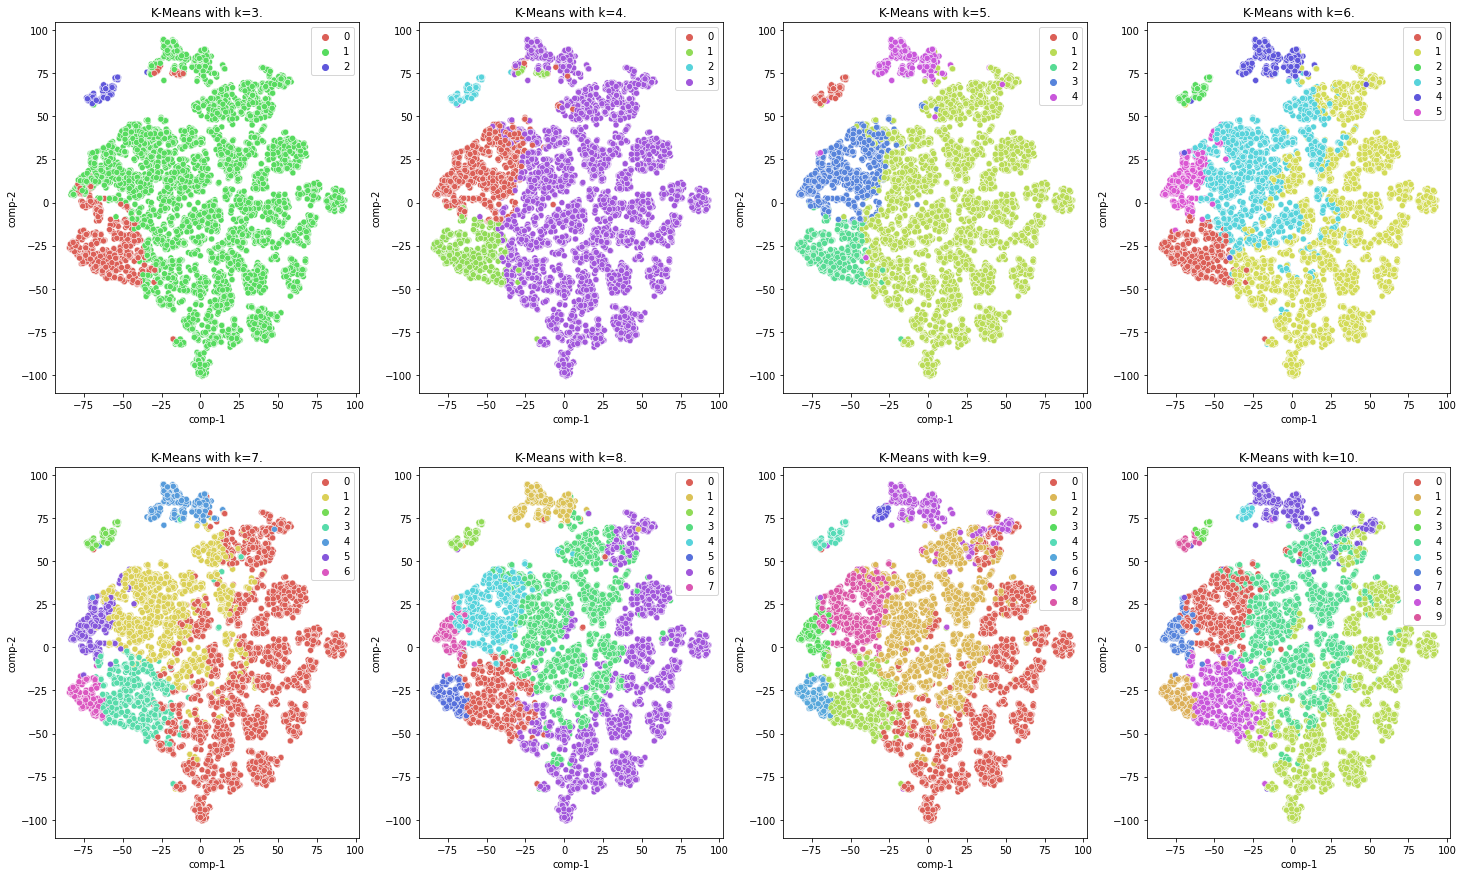

In [ ]:
lbls_km = []

K = [i for i in range(3, 11)]

i,j = 0, 0
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
for k in range(len(K)):
  km = cluster.KMeans(n_clusters=K[k])
  km.fit(physicdatanorm)
  y = km.predict(physicdatanorm)
  lbls_km.append(km.labels_)

  df = pd.DataFrame()
  df["y"] = lbls_km[-1]
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(ax=ax[i, j], x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", K[k]), data=df)
  ax[i][j].set(title="K-Means with k={}.".format(K[k]))
  j+=1
  if (j+1) > 4:
    i+=1
    j=0

###DBSCAN

In [ ]:
lbls_db = []
ncdbs = []

epss = [0.05, 0.1, 0.15, 0.2, 0.25]
min_spls = [[13, 15, 16, 17], [7, 10, 15, 18], [8, 10, 12, 14], [8, 12, 16, 20], [8, 16, 24, 32]]

fig, ax = plt.subplots(5, 4, figsize=(25, 25))
for e in range(len(epss)):
  for m in range(len(min_spls[e])):
    dbscan = cluster.DBSCAN(eps=epss[e], min_samples=min_spls[e][m])
    dbscan.fit(physicdatanorm) 
    y = dbscan.fit_predict(physicdatanorm)
    lbls_db.append(dbscan.labels_)
    ncdbs.append(len(np.unique(lbls_db[-1])))

    df = pd.DataFrame()
    df["y"] = lbls_db[-1]
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(ax=ax[e, m], x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", ncdbs[-1]), data=df)
    ax[e][m].set(title="DBSCAN with eps={}, min_samples={}. n_clusters={}".format(epss[e], min_spls[e][m], ncdbs[-1]))

Output hidden; open in https://colab.research.google.com to view.

###Agglomerative Clustering

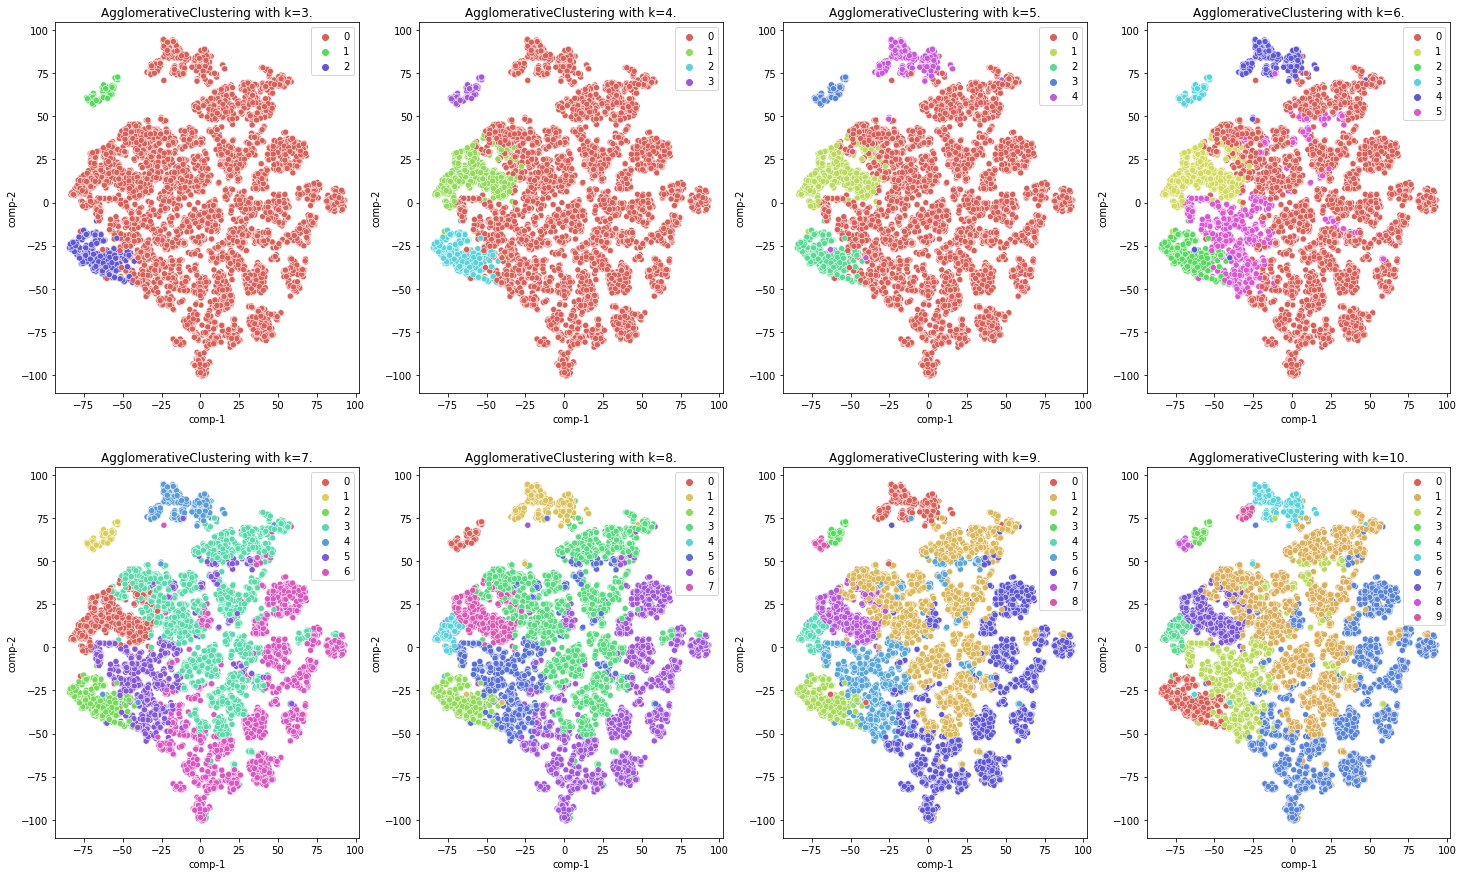

In [ ]:
lbls_ag = []

K = [i for i in range(3, 11)]

i,j = 0, 0
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
for k in range(len(K)):
  ag = cluster.AgglomerativeClustering(n_clusters=K[k])
  ag.fit(physicdatanorm)
  y = ag.fit_predict(physicdatanorm)
  lbls_ag.append(ag.labels_)

  df = pd.DataFrame()
  df["y"] = lbls_ag[-1]
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(ax=ax[i, j], x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", K[k]), data=df)
  ax[i][j].set(title="AgglomerativeClustering with k={}.".format(K[k]))
  j+=1
  if (j+1) > 4:
    i+=1
    j=0

###Spectral Clustering

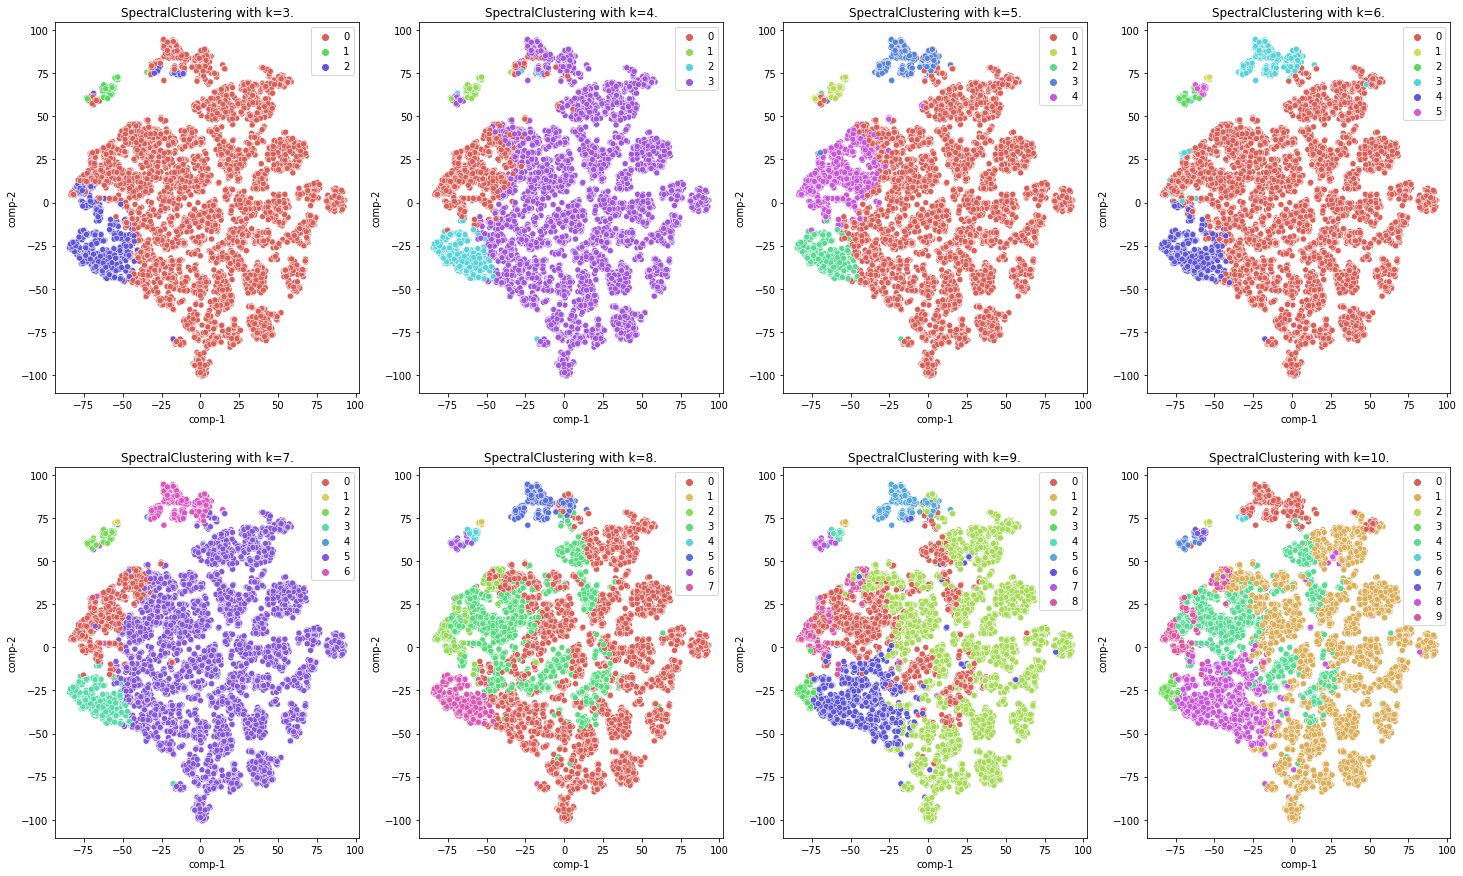

In [ ]:
lbls_sc = []

K = [i for i in range(3, 11)]

i,j = 0, 0
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
for k in range(len(K)):
  sc = cluster.SpectralClustering(n_clusters=K[k])
  sc.fit(physicdatanorm)
  y = sc.fit_predict(physicdatanorm)
  lbls_sc.append(sc.labels_)

  df = pd.DataFrame()
  df["y"] = lbls_sc[-1]
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(ax=ax[i, j], x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", K[k]), data=df)
  ax[i][j].set(title="SpectralClustering with k={}.".format(K[k]))
  j+=1
  if (j+1) > 4:
    i+=1
    j=0

###Gaussian Mixture

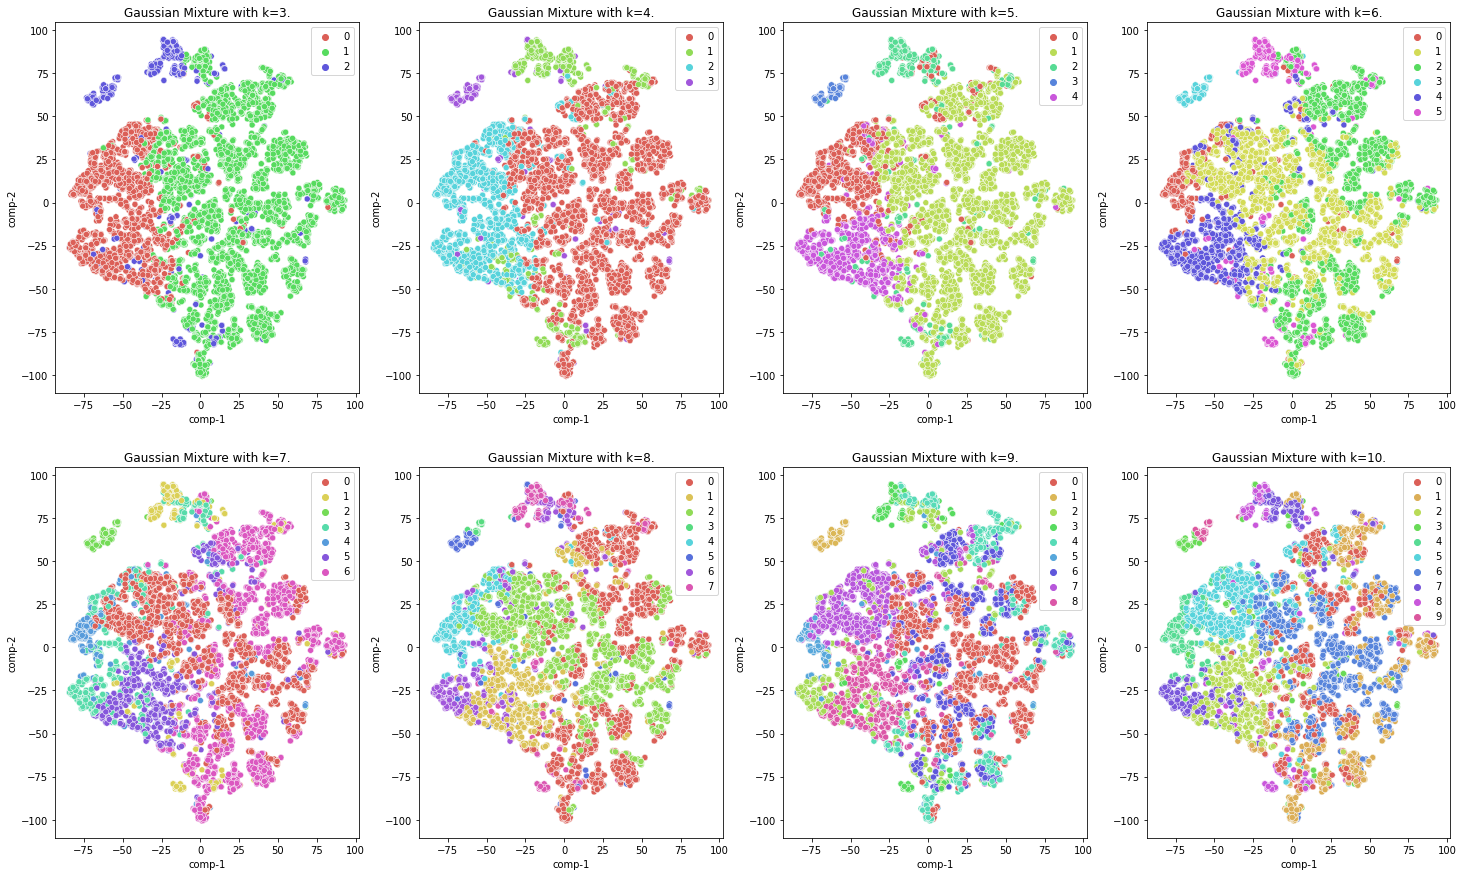

In [ ]:
lbls_gm = []

K = [i for i in range(3, 11)]

i,j = 0, 0
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
for k in range(len(K)):
  gm = gmm(n_components=K[k])
  gm.fit(physicdatanorm)
  lbls_gm.append(gm.predict(physicdatanorm))

  df = pd.DataFrame()
  df["y"] = lbls_gm[-1]
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(ax=ax[i, j], x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", K[k]), data=df)
  ax[i][j].set(title="Gaussian Mixture with k={}.".format(K[k]))
  j+=1
  if (j+1) > 4:
    i+=1
    j=0

###Medidas Internas

In [ ]:
dbs_km = [np.round(dbs(physicdatanorm, lbls_km[i]), 4) for i in range(len(lbls_km))]
dbs_ag = [np.round(dbs(physicdatanorm, lbls_ag[i]), 4) for i in range(len(lbls_ag))]
dbs_sc = [np.round(dbs(physicdatanorm, lbls_sc[i]), 4) for i in range(len(lbls_sc))]
dbs_gm = [np.round(dbs(physicdatanorm, lbls_gm[i]), 4) for i in range(len(lbls_gm))]
silavg_km = [np.round(silhouette_score(physicdatanorm, lbls_km[i]), 4) for i in range(len(lbls_km))]
silavg_ag = [np.round(silhouette_score(physicdatanorm, lbls_ag[i]), 4) for i in range(len(lbls_ag))]
silavg_sc = [np.round(silhouette_score(physicdatanorm, lbls_sc[i]), 4) for i in range(len(lbls_sc))]
silavg_gm = [np.round(silhouette_score(physicdatanorm, lbls_gm[i]), 4) for i in range(len(lbls_gm))]

internals = pd.DataFrame({'DaviesBoulding-Kmeans': dbs_km, 'Silhouette-Kmeans': silavg_km, 'DaviesBoulding-AgglomerativeClustering': dbs_ag,
                          'Silhouette-AgglomerativeClustering': silavg_ag, 'DaviesBoulding-SpectralClustering': dbs_sc, 'Silhouette-SpectralClustering': silavg_sc,
                          'DaviesBoulding-Gaussian Mixture': dbs_gm, 'Silhouette-Gaussian Mixture': silavg_gm}, index=K)
internals.index.name = "n_clusters"
internals

DaviesBoulding-Kmeans  Silhouette-Kmeans  \
n_clusters                                             
3                          0.9280             0.4882   
4                          0.9618             0.4078   
5                          0.9013             0.4277   
6                          1.0792             0.2601   
7                          1.0466             0.2661   
8                          1.1937             0.2031   
9                          1.1463             0.2087   
10                         1.1606             0.2078   

            DaviesBoulding-AgglomerativeClustering  \
n_clusters                                           
3                                           0.7019   
4                                           0.8728   
5                                           0.8676   
6                                           1.1163   
7                                           1.2854   
8                                           1.3183   
9                                           1.3148   
10                                          1.2676   

            Silhouette-AgglomerativeClustering  \
n_clusters                                       
3                                       0.5233   
4                                       0.4215   
5                                       0.4306   
6                                       0.2844   
7                                       0.1675   
8                                       0.1677   
9                                       0.1663   
10                                      0.1711   

            DaviesBoulding-SpectralClustering  Silhouette-SpectralClustering  \
n_clusters                                                                     
3                                      0.9223                         0.5147   
4                                      0.9719                         0.4310   
5                                      0.8628                         0.4349   
6                                      0.9238                         0.4633   
7                                      0.9066                         0.4489   
8                                      1.1116                         0.2559   
9                                      1.0539                         0.2613   
10                                     1.0007                         0.2675   

            DaviesBoulding-Gaussian Mixture  Silhouette-Gaussian Mixture  
n_clusters                                                                
3                                    1.8779                       0.3293  
4                                    1.6757                       0.2840  
5                                    1.2885                       0.3400  
6                                    1.5826                       0.0916  
7                                    2.0677                       0.0813  
8                                    1.9053                       0.0722  
9                                    2.5187                       0.0305  
10                                   2.0746                       0.0303

In [ ]:
idx = []
for i in epss:
  for j in min_spls[epss.index(i)]:
    idx.append(str(i)+'-'+str(j))

dbs_db = [np.round(dbs(physicdatanorm, lbls_db[i]), 4) for i in range(len(lbls_db))]
silavg_db = [np.round(silhouette_score(physicdatanorm, lbls_db[i]), 4) for i in range(len(lbls_db))]

internals_db = pd.DataFrame({'DaviesBoulding-DBSCAN': dbs_db, 'Silhouette-DBSCAN': silavg_db, 'N_clusters': ncdbs}, index=idx)
internals_db.index.name = "eps - min_samples"
internals_db

DaviesBoulding-DBSCAN  Silhouette-DBSCAN  N_clusters
eps - min_samples                                                      
0.05-13                           2.0515            -0.3004          13
0.05-15                           2.1976            -0.2666           9
0.05-16                           2.7425            -0.1494           5
0.05-17                           1.8485            -0.0064           4
0.1-7                             1.0836             0.4608          10
0.1-10                            1.4682             0.3308           7
0.1-15                            1.4349             0.5370           4
0.1-18                            1.6501             0.5332           3
0.15-8                            1.2297             0.6103           8
0.15-10                           1.2977             0.6167           7
0.15-12                           1.3613             0.6156           6
0.15-14                           1.4070             0.6165           5
0.2-8                             1.3507             0.6512           6
0.2-12                            1.3503             0.6653           5
0.2-16                            1.5320             0.6657           4
0.2-20                            1.5353             0.6642           4
0.25-8                            1.4658             0.6872           4
0.25-16                           1.4631             0.6864           4
0.25-24                           1.6806             0.6949           3
0.25-32                           1.7339             0.6962           3

In [ ]:
lbls = [lbls_km[silavg_km.index(max(silavg_km))], lbls_ag[silavg_ag.index(max(silavg_ag))], lbls_sc[silavg_sc.index(max(silavg_sc))], lbls_gm[silavg_gm.index(max(silavg_gm))]]
silavg = [max(silavg_km), max(silavg_ag), max(silavg_sc), max(silavg_gm)]
name = ["K-means with n_clustes={}".format(K[silavg_km.index(max(silavg_km))]),
        "AgglomerativeClustering with n_clustes={}".format(K[silavg_ag.index(max(silavg_ag))]),
        "SpectralClustering with n_clustes={}".format(K[silavg_sc.index(max(silavg_sc))]),
        "Gaussian Mixture with n_clustes={}".format(K[silavg_gm.index(max(silavg_gm))])]
ks = [K[silavg_km.index(max(silavg_km))], K[silavg_ag.index(max(silavg_ag))], K[silavg_sc.index(max(silavg_sc))], K[silavg_gm.index(max(silavg_gm))]]

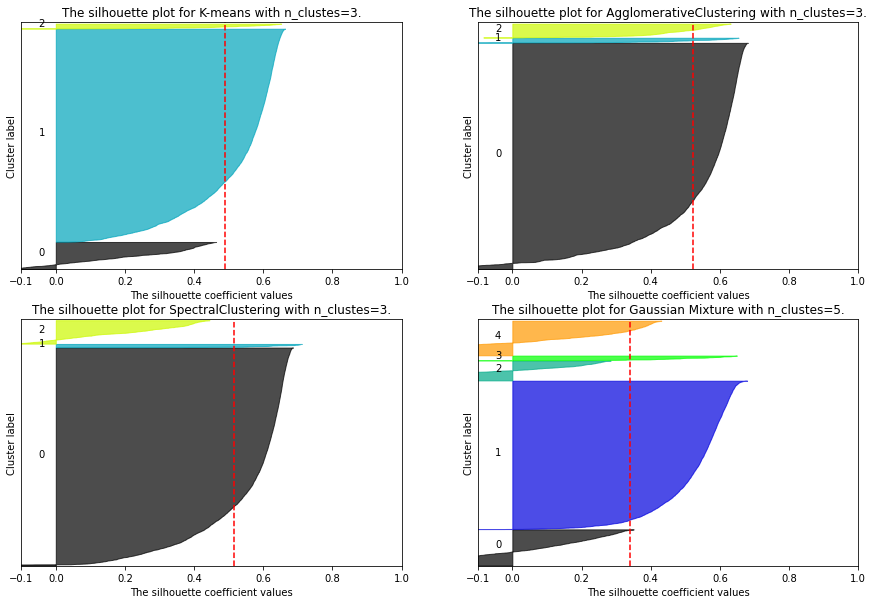

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
p, q = 0, 0

for m in range(len(lbls)):
  ax[p][q].set_xlim([-0.1, 1])
  ax[p][q].set_ylim([0, len(physicdatanorm) + (ks[m] + 1) * 20])

  sample_silhouette_values = silhouette_samples(physicdatanorm, lbls[m])

  y_lower = 10
  for i in range(ks[m]):
    ith_cluster_silhouette_values = sample_silhouette_values[lbls[m] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ks[m])
    ax[p][q].fill_betweenx( np.arange(y_lower, y_upper), 0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color, alpha=0.7)
    
    ax[p][q].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

  ax[p][q].set_title("The silhouette plot for {}.".format(name[m]))
  ax[p][q].set_xlabel("The silhouette coefficient values")
  ax[p][q].set_ylabel("Cluster label")

  ax[p][q].axvline(x=silavg[m], color="red", linestyle="--")

  ax[p][q].set_yticks([])
  ax[p][q].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  q += 1
  if (q+1)>2:
    p=1
    q=0

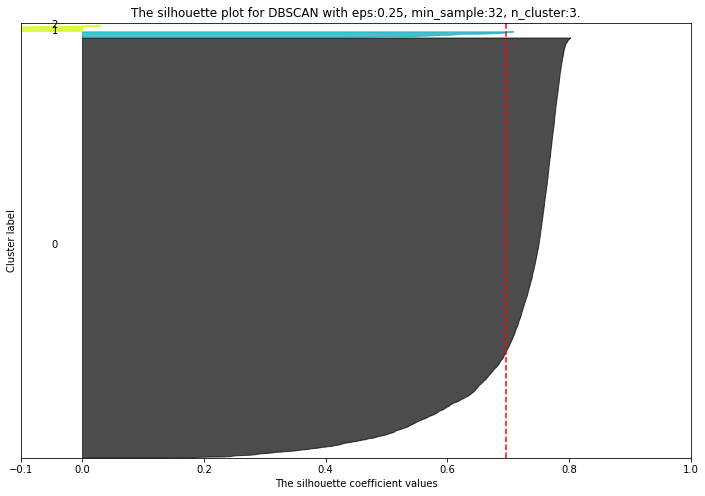

In [ ]:
best_lbl_db = lbls_db[silavg_db.index(max(silavg_db))]
best_lbl_db_fix = np.array([2 if i==-1 else i for i in best_lbl_db])
n_clus_db = internals_db.loc[internals_db['Silhouette-DBSCAN'] == max(silavg_db)]['N_clusters'][0]
best_eps = internals_db.loc[internals_db['Silhouette-DBSCAN'] == max(silavg_db)].index[0].split('-')[0]
best_min_samples = internals_db.loc[internals_db['Silhouette-DBSCAN'] == max(silavg_db)].index[0].split('-')[1]
name_db = "DBSCAN with eps:{}, min_sample:{}, n_cluster:{}".format(best_eps, best_min_samples, n_clus_db)

fig, ax = plt.subplots(figsize=(12,8))

ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(physicdatanorm) + (int(n_clus_db) + 1) * 20])

sample_silhouette_values = silhouette_samples(physicdatanorm, best_lbl_db_fix)

y_lower = 10
for i in range(int(n_clus_db)):
  ith_cluster_silhouette_values = sample_silhouette_values[best_lbl_db_fix == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / int(n_clus_db))
  ax.fill_betweenx( np.arange(y_lower, y_upper), 0,
      ith_cluster_silhouette_values,
      facecolor=color,
      edgecolor=color, alpha=0.7)
  
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
  y_lower = y_upper + 10

ax.set_title("The silhouette plot for {}.".format(name_db))
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

ax.axvline(x=max(silavg_db), color="red", linestyle="--")

ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

###Descripción del mejor clustering

In [ ]:
y = dbscan.fit_predict(physicdatanorm)
cluster_0 = physicdata.iloc[y==0,:]
cluster_1 = physicdata.iloc[y==1,:]
cluster_2 = physicdata.iloc[y==-1,:]

In [ ]:
cluster_0.describe()

Year          Price        Mileage       MinMPG       MaxMPG  \
count  8290.000000    8290.000000    8290.000000  8290.000000  8290.000000   
mean   2018.737756   39039.899156   37194.572376    20.775392    27.587575   
std       2.135078   18041.384479   24546.961348     4.326155     5.186065   
min    2002.000000    2300.000000     140.000000     0.000000     0.000000   
25%    2018.000000   28980.250000   18491.500000    18.000000    25.000000   
50%    2019.000000   35991.000000   32336.500000    20.000000    27.000000   
75%    2020.000000   45235.500000   47726.500000    23.000000    31.000000   
max    2022.000000  285000.000000  213000.000000    54.000000    50.000000   

         CarRating  ConsumerRating  SellerRating  
count  8290.000000     8290.000000   8290.000000  
mean      4.713902        4.719228      4.415742  
std       0.182984        0.193885      0.621411  
min       3.016667        3.100000      1.000000  
25%       4.666667        4.700000      4.300000  
50%       4.750000        4.800000      4.600000  
75%       4.816667        4.800000      4.800000  
max       5.000000        5.000000      5.000000

In [ ]:
cluster_1.describe()

Year         Price       Mileage      MinMPG      MaxMPG  \
count   111.000000    111.000000    111.000000  111.000000  111.000000   
mean   2019.873874  64411.486486  25200.738739  123.909910  112.468468   
std       1.079706  12200.349878  13151.485406   10.384035    7.137379   
min    2016.000000  29855.000000   3044.000000   99.000000   93.000000   
25%    2019.000000  56999.500000  14325.000000  118.000000  107.000000   
50%    2020.000000  67995.000000  22166.000000  127.000000  114.000000   
75%    2021.000000  71984.000000  34523.500000  131.000000  117.000000   
max    2022.000000  98488.000000  59745.000000  148.000000  132.000000   

        CarRating  ConsumerRating  SellerRating  
count  111.000000      111.000000    111.000000  
mean     4.298498        4.240541      4.491892  
std      0.400861        0.430091      0.382607  
min      3.816667        3.700000      3.400000  
25%      4.050000        4.000000      4.300000  
50%      4.050000        4.000000      4.600000  
75%      4.700000        4.700000      4.800000  
max      4.916667        4.900000      5.000000

In [ ]:
cluster_2.describe()

Year          Price        Mileage      MinMPG      MaxMPG  \
count   106.000000     106.000000     106.000000  106.000000  106.000000   
mean   2017.075472   83005.877358   45504.877358   69.688679   67.405660   
std       6.236144   84115.007915   60057.259697   53.556799   45.806379   
min    2001.000000    3995.000000     121.000000    0.000000    0.000000   
25%    2017.000000   50620.500000   12382.250000   15.250000   21.000000   
50%    2020.000000   65848.500000   19254.000000   75.000000   75.000000   
75%    2021.000000   91823.250000   46671.750000  118.000000  107.000000   
max    2022.000000  449996.000000  234114.000000  150.000000  133.000000   

        CarRating  ConsumerRating  SellerRating  
count  106.000000      106.000000    106.000000  
mean     3.935535        3.866981      3.920755  
std      0.703224        0.778854      1.070355  
min      2.666667        2.500000      1.000000  
25%      3.166667        3.000000      3.025000  
50%      4.058333        4.050000      4.400000  
75%      4.533333        4.500000      4.800000  
max      5.000000        5.000000      5.000000

In [ ]:
clusdeal = pd.DataFrame({"DealType": dataclean["DealType"], "Class":y})
gg = clusdeal.groupby(["Class"])
gg.get_group(0)["DealType"].value_counts()

Good     4905
Great    2115
Fair     1089
Name: DealType, dtype: int64

In [ ]:
gg.get_group(1)["DealType"].value_counts()

Good     74
Great    33
Fair      4
Name: DealType, dtype: int64

In [ ]:
gg.get_group(-1)["DealType"].value_counts()

Good     40
Great    32
Fair      9
Name: DealType, dtype: int64

##Clasificación

### Decision Tree

In [ ]:
DTdata = dataclean[["Year", "Price", "ConsumerRating", "ConsumerReviews", "SellerRating", "SellerReviews", "CarRating",
                   "MinMPG", "MaxMPG", "Mileage", "DealType"]]
DTdata.dropna(inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
DTnp = DTdata.to_numpy()

X = DTnp[:, 0:-1]
y = DTnp[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='gini', max_depth=4)
clf = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["0: Fair", "1: Good", "2: Great"]))

              precision    recall  f1-score   support

     0: Fair       0.50      0.09      0.15       221
     1: Good       0.62      0.91      0.74      1004
    2: Great       0.41      0.14      0.21       436

    accuracy                           0.60      1661
   macro avg       0.51      0.38      0.37      1661
weighted avg       0.55      0.60      0.52      1661



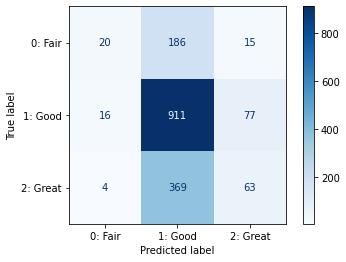

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_pred, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

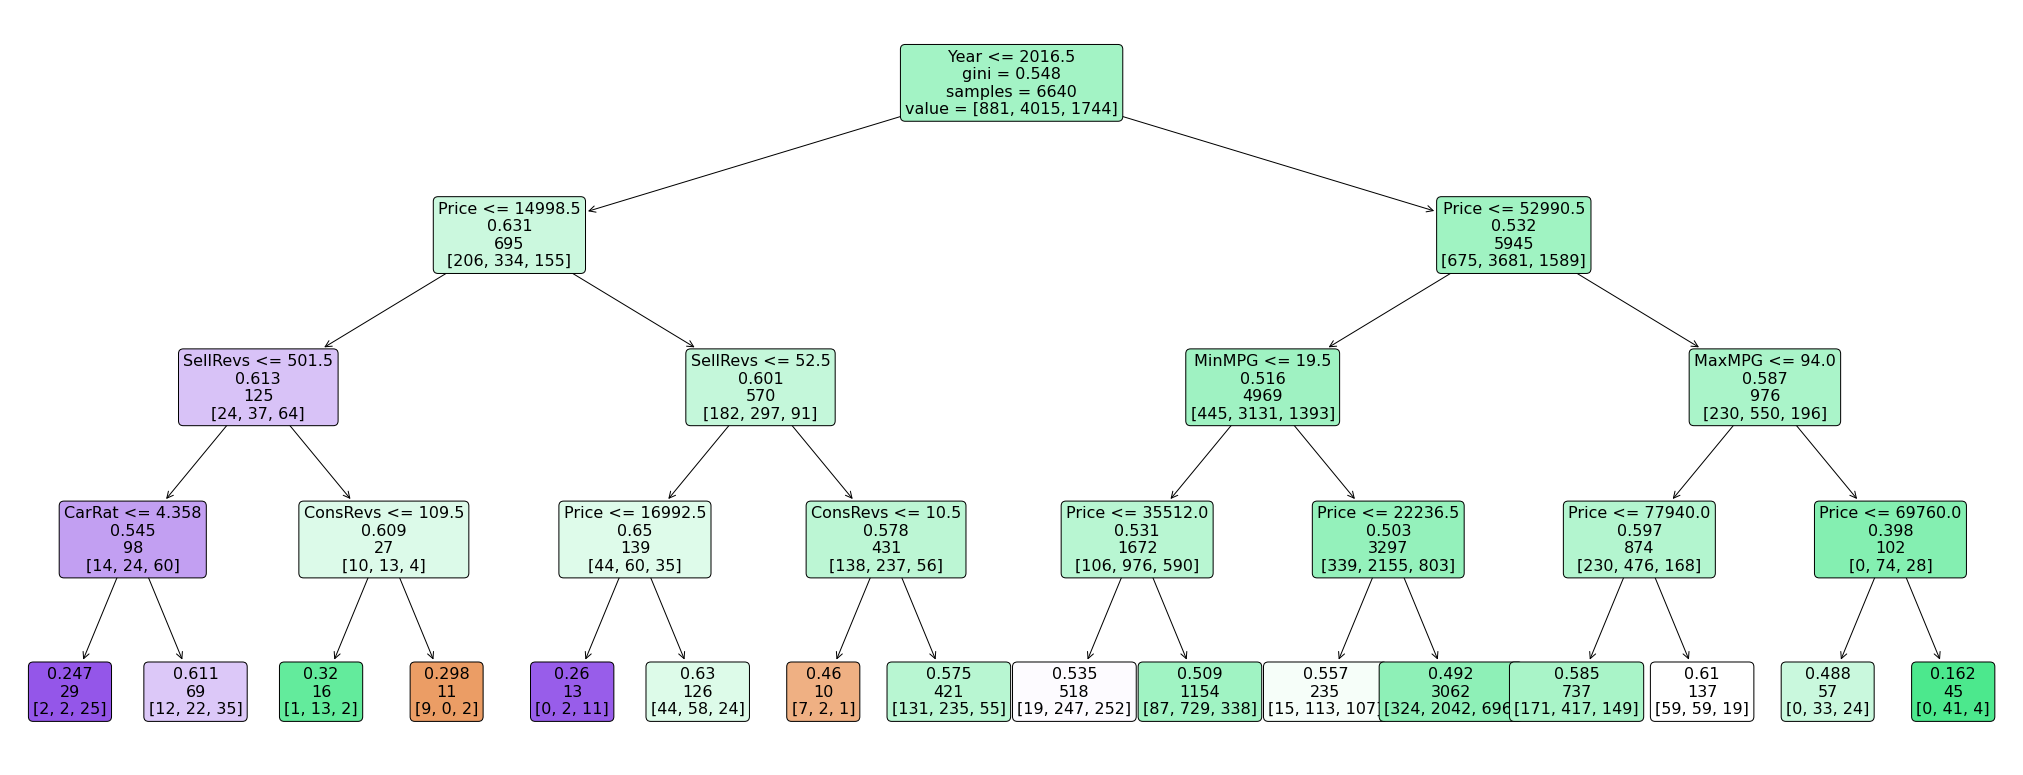

In [ ]:
import sklearn.tree

cols = ["Year", "Price", "ConsRat", "ConsRevs", "SellRat", "SellRevs", "CarRat",
                   "MinMPG", "MaxMPG", "Mileage"]

plt.figure(figsize=(36,14))
sklearn.tree.plot_tree(clf, feature_names=cols, fontsize=16, filled=True, rounded=True, label='root')
plt.show()

### Naive-Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = bayes.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["0: Fair", "1: Good", "2: Great"]))

              precision    recall  f1-score   support

     0: Fair       0.40      0.33      0.36       221
     1: Good       0.63      0.87      0.73      1004
    2: Great       0.38      0.06      0.11       436

    accuracy                           0.59      1661
   macro avg       0.47      0.42      0.40      1661
weighted avg       0.53      0.59      0.52      1661



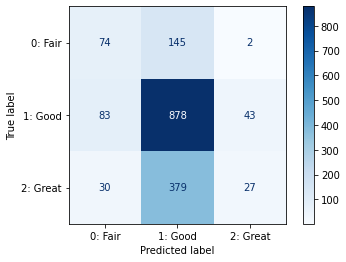

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_pred, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

NBCdata = dataclean[["Make", "Model", "State", "Engine", "DealType"]]
NBCdata = NBCdata.dropna()

NBCd = NBCdata.to_numpy()

X = NBCd[:, 0:-1]
y = NBCd[:, -1]

enc = OrdinalEncoder()
X = enc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': list(range(4,100))}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, verbose=2, cv=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=6; total time=   0.1s
[CV] END ......................................

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                         25, 26, 27, 28, 29, 30, 31, 32, 33, ...]},
             verbose=2)

In [ ]:
results_knn = clf.cv_results_['mean_test_score']

results_knn = dict(zip(param_grid["n_neighbors"], results_knn))

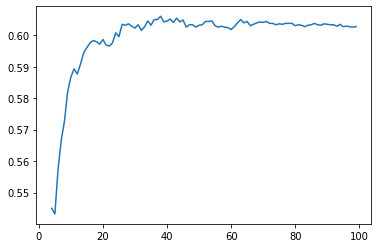

In [ ]:
sns.lineplot(data=results_knn)

In [ ]:
clf.best_params_

{'n_neighbors': 38}

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["0: Fair", "1: Good", "2: Great"]))

              precision    recall  f1-score   support

     0: Fair       0.41      0.05      0.09       221
     1: Good       0.61      0.97      0.75      1004
    2: Great       0.34      0.03      0.06       436

    accuracy                           0.60      1661
   macro avg       0.45      0.35      0.30      1661
weighted avg       0.51      0.60      0.48      1661



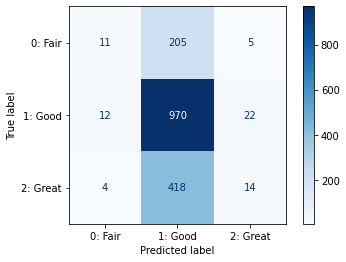

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_pred, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [2**i for i in range(2,11)], 'max_features': [0.1*i for i in range(1,11)]}

clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=2, cv=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ...................max_features=0.1, n_estimators=4; total time=   0.2s
[CV] END ...................max_features=0.1, n_estimators=4; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=4; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=4; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=4; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=8; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=8; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=8; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=8; total time=   0.1s
[CV] END ...................max_features=0.1, n_estimators=8; total time=   0.2s
[CV] END ..................max_features=0.1, n_estimators=16; total time=   0.2s
[CV] END ..................max_features=0.1, n_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [0.1, 0.2, 0.30000000000000004, 0.4,
                                          0.5, 0.6000000000000001,
                                          0.7000000000000001, 0.8, 0.9, 1.0],
                         'n_estimators': [4, 8, 16, 32, 64, 128, 256, 512,
                                          1024]},
             verbose=2)

In [ ]:
results_rf = clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_features']),
                                                    len(param_grid['n_estimators']))

results_rf

array([[0.56731928, 0.5938253 , 0.60888554, 0.62078313, 0.62620482,
        0.6310241 , 0.62740964, 0.6314759 , 0.62891566],
       [0.57078313, 0.59292169, 0.61069277, 0.62183735, 0.6253012 ,
        0.62891566, 0.63162651, 0.63448795, 0.63192771],
       [0.57228916, 0.59533133, 0.61325301, 0.62424699, 0.62831325,
        0.63192771, 0.63237952, 0.63192771, 0.63493976],
       [0.57153614, 0.58644578, 0.61490964, 0.62123494, 0.62695783,
        0.63222892, 0.63343373, 0.63222892, 0.6313253 ],
       [0.57018072, 0.59623494, 0.61325301, 0.6248494 , 0.62635542,
        0.63072289, 0.62740964, 0.63012048, 0.63087349],
       [0.57093373, 0.60045181, 0.62168675, 0.62756024, 0.62996988,
        0.6310241 , 0.62996988, 0.62876506, 0.62861446],
       [0.56686747, 0.60707831, 0.61370482, 0.61807229, 0.625     ,
        0.62665663, 0.63057229, 0.62710843, 0.62936747],
       [0.57665663, 0.59849398, 0.60993976, 0.62996988, 0.62424699,
        0.62921687, 0.62876506, 0.62981928, 0.62951807],


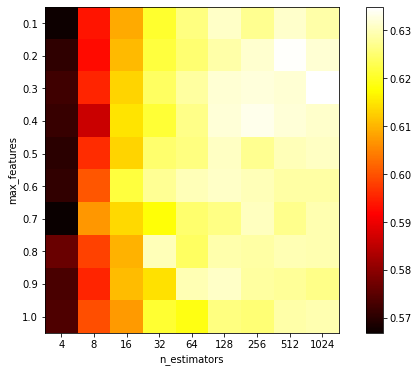

In [ ]:
import pylab as pl

pl.figure(figsize=(10, 6))
#wpl.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
pl.imshow(results_rf, interpolation='nearest', cmap=plt.cm.hot)
pl.xlabel('n_estimators'); plt.xticks(range(9), param_grid["n_estimators"])
pl.ylabel('max_features'); plt.yticks(range(10), np.round(param_grid["max_features"],1))
pl.colorbar()
pl.show()

In [ ]:
clf.best_params_

{'max_features': 0.30000000000000004, 'n_estimators': 1024}

In [ ]:
clf = RandomForestClassifier(n_estimators=1024, max_features=0.3)

clf.fit(X_train, y_train)

array([0.05005912, 0.19003399, 0.03665299, 0.10304898, 0.09033487,
       0.1467051 , 0.07710565, 0.06649051, 0.0724162 , 0.16715259])

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["0: Fair", "1: Good", "2: Great"]))

              precision    recall  f1-score   support

     0: Fair       0.65      0.25      0.36       221
     1: Good       0.66      0.89      0.76      1004
    2: Great       0.56      0.27      0.36       436

    accuracy                           0.64      1661
   macro avg       0.62      0.47      0.49      1661
weighted avg       0.63      0.64      0.60      1661



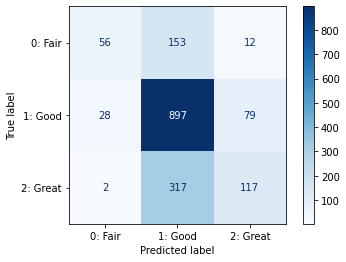

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_pred, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

In [ ]:
importances = clf.feature_importances_
np.argsort(importances)
for i in np.argsort(importances)[::-1]: print(DTdata.columns[i])

Price
Mileage
SellerReviews
ConsumerReviews
SellerRating
CarRating
MaxMPG
MinMPG
Year
ConsumerRating


###Red Neuronal

In [ ]:
NNdata = dataclean[["Year", "Price", "ConsumerRating", "ConsumerReviews", "SellerRating", "SellerReviews", "CarRating",
                   "MinMPG", "MaxMPG", "Mileage", "DealType"]]
NNdata = NNdata.dropna()
NNdata["DealType"] = NNdata["DealType"].astype('category').cat.codes

for name in ["Year", "Price", "ConsumerRating", "ConsumerReviews", "SellerRating", "SellerReviews", "CarRating", "MinMPG", "MaxMPG", "Mileage"]:
    NNdata[name] = NNdata[name].astype('float32')
NNdata

Year    Price  ConsumerRating  ConsumerReviews  SellerRating  \
0     2019.0  39998.0             4.6             45.0           3.3   
1     2018.0  49985.0             4.8            817.0           4.8   
2     2017.0  41860.0             4.7            495.0           4.6   
4     2020.0  49000.0             4.8             76.0           4.8   
5     2012.0  23541.0             4.7             34.0           4.4   
...      ...      ...             ...              ...           ...   
9373  2019.0  31999.0             4.8            540.0           4.8   
9374  2019.0  27374.0             4.7            205.0           4.4   
9376  2017.0  26944.0             4.8            137.0           4.7   
9377  2019.0  28568.0             4.7            279.0           4.4   
9378  2019.0  32091.0             4.8            204.0           4.4   

      SellerReviews  CarRating  MinMPG  MaxMPG   Mileage  DealType  
0               3.0   4.600000    19.0    27.0   29403.0         2  
1             131.0   4.766667    19.0    24.0   32929.0         1  
2             249.0   4.733333    15.0    21.0   23173.0         1  
4            4755.0   4.816667    20.0    27.0   28137.0         1  
5            1071.0   4.683333    17.0    23.0  105469.0         0  
...             ...        ...     ...     ...       ...       ...  
9373         1917.0   4.766667    27.0    33.0   44481.0         1  
9374          443.0   4.716667    27.0    33.0   15606.0         1  
9376          831.0   4.783333    15.0    22.0   62649.0         1  
9377          680.0   4.716667    26.0    33.0   30760.0         1  
9378         1105.0   4.816667    21.0    27.0   41645.0         1  

[8301 rows x 11 columns]

In [ ]:
NN0 = NNdata[NNdata["DealType"]==0]
NN1 = NNdata[NNdata["DealType"]==1]
NN2 = NNdata[NNdata["DealType"]==2]
NN0.shape, NN1.shape, NN2.shape

((1102, 11), (5019, 11), (2180, 11))

In [ ]:
X_train = np.concatenate((NN0.to_numpy()[:850, 0:-1], NN1.to_numpy()[:850, 0:-1], NN2.to_numpy()[:850, 0:-1]))
y_train = np.concatenate((NN0.to_numpy()[:850, -1], NN1.to_numpy()[:850, -1], NN2.to_numpy()[:850, -1]))
X_test = np.concatenate((NN0.to_numpy()[850:, 0:-1], NN1.to_numpy()[850:, 0:-1], NN2.to_numpy()[850:, 0:-1]))
y_test = np.concatenate((NN0.to_numpy()[850:, -1], NN1.to_numpy()[850:, -1], NN2.to_numpy()[850:, -1]))

skencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train = skencoder.fit_transform(y_train.reshape(-1, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2550, 10), (2550, 3), (5751, 10), (5751,))

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_train.shape, y_train.shape

((2550, 10), (2550, 3))

In [ ]:
model = Sequential()
model.add(Dense(6, input_shape=(10,), activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
40/40 [==============================] - 1s 2ms/step - loss: 2955.7288 - accuracy: 0.3267
Epoch 2/25
40/40 [==============================] - 0s 2ms/step - loss: 2763.6890 - accuracy: 0.3204
Epoch 3/25
40/40 [==============================] - 0s 2ms/step - loss: 2608.0090 - accuracy: 0.3208
Epoch 4/25
40/40 [==============================] - 0s 2ms/step - loss: 2474.5791 - accuracy: 0.3196
Epoch 5/25
40/40 [==============================] - 0s 2ms/step - loss: 2352.6250 - accuracy: 0.3204
Epoch 6/25
40/40 [==============================] - 0s 2ms/step - loss: 2239.2463 - accuracy: 0.3247
Epoch 7/25
40/40 [==============================] - 0s 2ms/step - loss: 2132.4253 - accuracy: 0.3275
Epoch 8/25
40/40 [==============================] - 0s 2ms/step - loss: 2032.2981 - accuracy: 0.3286
Epoch 9/25
40/40 [==============================] - 0s 2ms/step - loss: 1932.2012 - accuracy: 0.3306
Epoch 10/25
40/40 [==============================] - 0s 2ms/step - loss: 1837.4696 - accura

In [ ]:
y_pred = model.predict(X_test)
y_p = [np.argmax(i) for i in y_pred]
y_p
print(classification_report(y_test, y_p, target_names=["0: Fair", "1: Good", "2: Great"]))

180/180 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     0: Fair       0.04      0.45      0.08       252
     1: Good       0.71      0.22      0.33      4169
    2: Great       0.22      0.32      0.26      1330

    accuracy                           0.25      5751
   macro avg       0.33      0.33      0.23      5751
weighted avg       0.57      0.25      0.31      5751



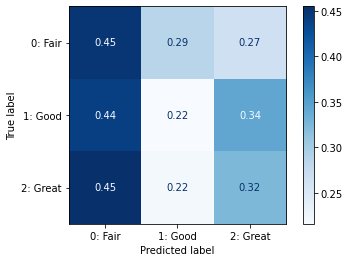

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_p, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues', normalize='true')

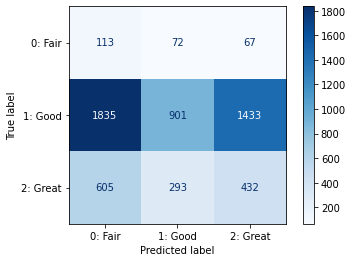

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, y_p, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

In [ ]:
NNd = NNdata.to_numpy()

In [ ]:
X = NNd[:, 0:-1]
y = NNd[:, -1]

skencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
sk_y = skencoder.fit_transform(y.reshape(-1, 1))

model = Sequential()
model.add(Dense(6, input_shape=(10,), activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model.fit(X, sk_y, epochs=25, batch_size=128)

Epoch 1/25
65/65 [==============================] - 1s 2ms/step - loss: 9531.8740 - accuracy: 0.1328
Epoch 2/25
65/65 [==============================] - 0s 2ms/step - loss: 8324.6758 - accuracy: 0.1328
Epoch 3/25
65/65 [==============================] - 0s 2ms/step - loss: 7118.8232 - accuracy: 0.1328
Epoch 4/25
65/65 [==============================] - 0s 2ms/step - loss: 5911.3164 - accuracy: 0.1328
Epoch 5/25
65/65 [==============================] - 0s 2ms/step - loss: 4700.2554 - accuracy: 0.1323
Epoch 6/25
65/65 [==============================] - 0s 2ms/step - loss: 3568.3997 - accuracy: 0.1419
Epoch 7/25
65/65 [==============================] - 0s 2ms/step - loss: 2857.0161 - accuracy: 0.1766
Epoch 8/25
65/65 [==============================] - 0s 2ms/step - loss: 2548.4561 - accuracy: 0.2433
Epoch 9/25
65/65 [==============================] - 0s 2ms/step - loss: 2381.6516 - accuracy: 0.2932
Epoch 10/25
65/65 [==============================] - 0s 2ms/step - loss: 2257.9534 - accura

In [ ]:
y_pred = model.predict(X)
y_p = [np.argmax(i) for i in y_pred]
y_p
print(classification_report(y, y_p, target_names=["0: Fair", "1: Good", "2: Great"]))

260/260 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     0: Fair       0.14      0.25      0.18      1102
     1: Good       0.62      0.50      0.55      5019
    2: Great       0.26      0.28      0.27      2180

    accuracy                           0.41      8301
   macro avg       0.34      0.34      0.33      8301
weighted avg       0.46      0.41      0.43      8301



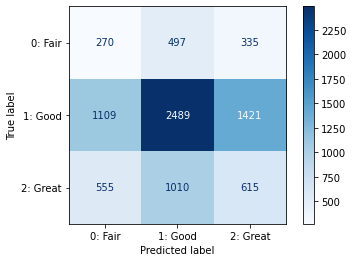

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y, y_p, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues')

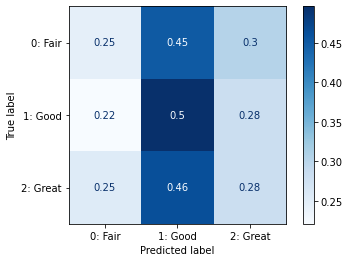

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y, y_p, display_labels=["0: Fair", "1: Good", "2: Great"], cmap='Blues', normalize='true')